In [1]:
# Logistic Regression Model for Lead Conversion Prediction

In [2]:
# 1. Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as ssm
import warnings

from matplotlib.colors import LinearSegmentedColormap
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, r2_score, classification_report 
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")

In [3]:
# 2. Data Loading
data = pd.read_csv('leads.csv')  # Replace with actual file path
data.head()

Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit  ...  \
0                            0                   0.0  ...   
1                          674                   2.5  ...   
2                         1532                   2.0  ...   
3                          305                   1.0  ...   
4                         1428                   1.0  ...   

  Get updates on DM Content    Lead Profile    City  \
0                        No          Select  Select   
1                        No          Select  Select   
2                        No  Potential Lead  Mumbai   
3                        No          Select  Mumbai   
4                        No          Select  Mumbai   

  Asymmetrique Activity Index Asymmetrique Profile Index  \
0                   02.Medium                  02.Medium   
1                   02.Medium                  02.Medium   
2                   02.Medium                    01.High   
3                   02.Medium                    01.High   
4                   02.Medium                    01.High   

  Asymmetrique Activity Score Asymmetrique Profile Score  \
0                        15.0                       15.0   
1                        15.0                       15.0   
2                        14.0                       20.0   
3                        13.0                       17.0   
4                        15.0                       18.0   

  I agree to pay the amount through cheque  \
0                                       No   
1                                       No   
2                                       No   
3                                       No   
4                                       No   

  A free copy of Mastering The Interview Last Notable Activity  
0                                     No              Modified  
1                                     No          Email Opened  
2                                    Yes          Email Opened  
3                                     No              Modified  
4                                     No              Modified  

[5 rows x 37 columns]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [5]:
data.shape

(9240, 37)

In [6]:
# Checking for missing values
missing_values = data.isnull().sum().sort_values(ascending=False)
print("Missing Values:\n", missing_values)

Missing Values:
 Lead Quality                                     4767
Asymmetrique Activity Index                      4218
Asymmetrique Profile Score                       4218
Asymmetrique Activity Score                      4218
Asymmetrique Profile Index                       4218
Tags                                             3353
Lead Profile                                     2709
What matters most to you in choosing a course    2709
What is your current occupation                  2690
Country                                          2461
How did you hear about X Education               2207
Specialization                                   1438
City                                             1420
Page Views Per Visit                              137
TotalVisits                                       137
Last Activity                                     103
Lead Source                                        36
Receive More Updates About Our Courses              0
I agree to 

In [7]:
data.shape

(9240, 37)

In [8]:
## 3. Data Exploration and Cleaning

In [101]:

# Plot function for value counts
def value_count_plots(dfs, columns, labels=[], size=[10, 10], ncols=3, vertical= False, rotation= 0):
    '''
    dfs: list of dataframes or dataframe
    columns: columns of dataframe(s) to be plotted (dataframe column names)
    labels: labels assigned to split bar plots (list of strings with length = dataframe list)
    size: size of plot as in plt.figure(figsize=( , )) (tuple, list)
    ncols: number of columns in the plot (int)
    vertical: for vertical/horizontal bar plots (bool)
    rotation: rotation angle in degrees for x_labels (int)
    '''
    if len(columns) % ncols != 0:
        nrows = len(columns) // ncols + 1
    else:
        nrows = len(columns) // ncols

    idx = 1
    plt.figure(figsize= size, layout='tight')   
    for col in columns:     # one graph per column
        ax = plt.subplot(nrows, ncols, idx)
        if type(dfs) == list:
            barheight, height = 0.0, 0.3
            barwidth, width = 0.0, 0.3
            for df, label in zip(dfs, labels):   # one plot for each df
                if vertical: 
                    x_pos = np.arange(df[col].value_counts(normalize= True).index.size)
                    x_ticks = df[col].value_counts(normalize= True).index
                    ax.bar(x_pos + barwidth, 
                        df[col].value_counts(normalize= True).values,
                        width, 
                        label=label)
                    ax.set_xlabel(col)
                    ax.set_xticks(x_pos + width/2*(len(dfs)-1), x_ticks, rotation=rotation)
                    barwidth += 0.3
                else:
                    # barheight, height = 0.0, 0.3
                    y_pos = np.arange(df[col].value_counts(normalize= True).index.size)
                    y_ticks = df[col].value_counts(normalize= True).index
                    ax.barh(y_pos + barheight, 
                            df[col].value_counts(normalize= True).values,
                            height, 
                            label=label)
                    ax.set_xlabel(col)
                    ax.set_yticks(y_pos + height/2*(len(dfs)-1), y_ticks, rotation=rotation)
                    barheight += 0.3
        else:
            ax.barh(dfs[col].value_counts(normalize= True).index, 
            dfs[col].value_counts(normalize= True).values)
            ax.set_xlabel(col)
        idx += 1
        plt.legend()
    plt.show()

# Plot function for histogram
def histogram_plots(dfs, columns, labels=[], size=[10, 10], ncols=3):
    '''
    dfs: list of dataframes or dataframe
    columns: columns of dataframe(s) to be plotted (dataframe column names)
    labels: labels assigned to split bar plots (list of strings with length = dataframe list)
    size: size of plot as in plt.figure(figsize=( , )) (tuple, list)
    ncols: number of columns in the plot (int)  
    '''
    if len(columns) % ncols != 0:
        nrows = len(columns) // ncols + 1
    else:
        nrows = len(columns) // ncols

    idx = 1
    plt.figure(figsize= size, layout='tight')
    for col in columns:
        if idx == 3:
            ax.set_title('Histogram for numeric types')
        ax = plt.subplot(nrows, ncols, idx)
        if type(dfs) == list:
            for df, align, label in zip(dfs, ['left', 'right'], labels):
                ax.hist(df[col], align= align, label= label, density= True)
                ax.set_xlabel(col)
        else:
            ax.hist(dfs[col], density= True)
            ax.set_xlabel(col)
        idx += 1
        plt.legend()
    plt.show()

#  Plot function for boxplots
def box_plots(df, num_cols, cat_cols=[], size=[10, 10], ncols=3, vertical=True, rotation=0):
    '''
    df: dataframe
    num_cols: numeric type columns of dataframe to be plotted (dataframe column names)
    cat_cols: category type columns against whose unique values boxplot of numeric columns will be plotted
    size: size of plot as in plt.figure(figsize=( , )) (tuple, list)
    ncols: number of columns in the plot (int)
    vertical: for vertical/horizontal box plots (bool)
    rotation: rotation angle in degrees for x_labels (int)
    '''
    import matplotlib.pyplot as plt
    import numpy as np
    
    if len(cat_cols) > 0:  # Numeric spread for each category value
        if len(cat_cols) % ncols != 0:
            nrows = len(cat_cols) // ncols + 1
        else:
            nrows = len(cat_cols) // ncols
        idx = 1
        plt.figure(figsize=size)
        for row in cat_cols:
            ax = plt.subplot(nrows, ncols, idx)
            for col in num_cols:
                if vertical:  # Vertical boxplot
                    ax.boxplot([df[df[row] == val][col] for val in df[row].unique()])
                    ax.set_xticks(np.arange(1, df[row].nunique() + 1))
                    ax.set_xticklabels(df[row][~df[row].isnull()].unique(), rotation=rotation)
                    ax.set_xlabel(row)
                    ax.set_ylabel(col)
                else:  # Horizontal boxplot
                    ax.boxplot([df[df[row] == val][col] for val in df[row].unique()], vert=False)
                    ax.set_yticks(np.arange(1, df[row].nunique() + 1))
                    ax.set_yticklabels(df[row][~df[row].isnull()].unique(), rotation=rotation)
                    ax.set_xlabel(col)
                    ax.set_ylabel(row)
            idx += 1
        plt.tight_layout()
        plt.show()

    else:  # Numeric spread only
        if len(num_cols) % ncols != 0:
            nrows = len(num_cols) // ncols + 1
        else:
            nrows = len(num_cols) // ncols
        idx = 1
        plt.figure(figsize=size)
        for col in num_cols:
            ax = plt.subplot(nrows, ncols, idx)
            if vertical:
                ax.boxplot(df[col])
                ax.set_title(col)
            else:
                ax.boxplot(df[col], vert=False)
                ax.set_title(col)
            idx += 1
        plt.tight_layout()
        plt.show()

# Store null columns in a dataframe
def fetch_nulls(df):
    '''
    df: dataframe whose column names, dtypes, percent nulls have to be fetched
    '''
    nulls = df.isnull().sum()
    condition = df.isnull().sum() > 0

    df_nulls = pd.concat([df[nulls[condition].index].dtypes, (nulls[condition] / len(df) * 100).round(2)], axis=1).reset_index()
    df_nulls.columns = ['Column_name', 'dtype', 'percent_nulls']
    df_nulls.sort_values(by= 'percent_nulls', ascending= False)
    return df_nulls

# Function to plot correlation heatmap in grayscale
def corr_heatmap(df, cols, size=(8, 8)):
    '''
    df: dataframe
    cols: numeric type columns of dataframe to be plotted (dataframe column names)
    size: size of plot as in plt.figure(figsize=( , )) (tuple, list)
    '''
    heatmap_clr = [
    (0, 'black'),
    (0.25, 'grey'),
    (0.5, 'white'),
    (0.75, 'grey'),
    (1.0, 'black')
    ]
    heatmap_cmap = LinearSegmentedColormap.from_list('Heatmap_Palette', heatmap_clr)
    df = df[cols].corr()
    plt.figure(figsize=size)
    sns.heatmap(df, mask= np.triu(df, k= 0), cmap= heatmap_cmap, center= 0.0)
    plt.show()

# Function to plot sigmoid curve of predicted values
def plot_sigmoid(X, y, model, axis= None, title= None):
    '''
    X: dataset based on which model is trained
    y: target vector
    model: trained model on X and y
    axis: for passing pyplot axis type value
    title: title for sigmoid curve (string)
    '''
    if axis:

        axis.plot(sorted(model.predict_proba(X)[:, 1]))
        axis.plot(sorted(y))
        if title:
            axis.set_title(f'{title} sigmoid curve')
        else:
            axis.set_title(f'Sigmoid curve')
        return axis
    else:
        plt.plot(sorted(model.predict_proba(X)[:, 1]))
        plt.plot(sorted(y))
        plt.title('Sigmoid curve')
        plt.show()

# function for plotting ROC curve of trained model
def plot_roc(X, y, model, axis= None, title= None):
    '''
    X: dataset based on which model is trained
    y: target vector
    model: trained model on X and y
    axis: for passing pyplot axis type value
    title: title for sigmoid curve (string)
    '''
    roc = roc_curve(y, model.predict_proba(X)[:, 1])
    auc = roc_auc_score(y, model.predict_proba(X)[:, 1])
    if axis:
        axis.scatter(roc[0], roc[1])
        if title:
            axis.set_title(f'{title} ROC, AUC= {round(auc, 3)}')
        else:
            axis.set_title(f'{title} ROC, AUC= {round(auc, 3)}')
        return axis
    else:
        plt.scatter(roc[0], roc[1])
        plt.title(f'{title} ROC, AUC= {round(auc, 3)}')
        plt.show()

# transform function for woe (ln(category_true / total_true) - ln(category_false / total_false))
# works only for binary target feature
def woe(x, df):
    '''
    x: Series type passed by lambda function of pd.groupby().transform
    df: dataframe for calculating total_true and total_false
    '''
    P = x.sum()                     # converted for each category groupby value
    N = x.count() - x.sum()         # non convertedfor each category groupby value
    t_pos = df['Converted'].sum()
    t_neg = len(df) - df['Converted'].sum()
    if P == 0 or N == 0:
        return 0                    # since log(0) is indefined
    else:
        return np.log(P / t_pos) - np.log(N / t_neg)

# transform function for log-odds (ln(category_true / category_false))
def log_odd(x):
    '''
    x: Series type passed by lambda function of pd.groupby().transform
    '''
    P = x.sum()                 # converted for each category groupby value
    N = x.count() - x.sum()     # non convertedfor each category groupby value
    if P == 0 or N == 0:
        return 0                # since log(0) is indefined
    else:
        return np.log(P / N)

# transform function for ratio-difference to calculate information value
# ratio_diff = category_true / total_true - category_false / total_false
def ratio_diff(x, df):
    '''
    x: Series type passed by lambda function of pd.groupby().transform
    df: dataframe for calculating total_true and total_false
    '''
    P = x.sum()                 # converted for each category groupby value
    N = x.count() - x.sum()     # non convertedfor each category groupby value
    t_pos = df['Converted'].sum()               # total converted (1s)
    t_neg = len(df) - df['Converted'].sum()     # total non-converted (0s)
    return P / t_pos - N / t_neg
    
# transformer for grouping category columns and calling calling woe, logodd, ratio transform functions
def transform_catgory(df, col, target, func):
    '''
    df: dataframe from which total_true and total_false is calculated
    col: dataframe columns on which pd.groupby() is called
    target: target column whose total values are calculated from passed dataframe
    func: woe / logodd / ratio transform functions

    returns grouped transformed values for each unique category values
    '''
    if func == log_odd:
        return df.groupby(col)[target].transform(lambda x: func(x))
    else:
        return df.groupby(col)[target].transform(lambda x: func(x, df))

# function to cap outliers to given times of IQR range of numeric column
def cap_outlier(col, times_iqr= 1.5):
    '''
    col: numeric column whose outlier is to be capped (dataframe columns name)
    times_iqr: #times of IQR range of col to which values beyond it are capped to
    '''
    iqr = np.percentile(col, 75) - np.percentile(col, 25)
    upper = np.percentile(col, 75) + iqr * times_iqr
    lower = np.percentile(col, 25) - iqr * times_iqr
    cond_h = col > upper
    cond_l = col < lower
    col = np.where(cond_h, upper, col)
    col = np.where(cond_l, lower, col)
    return col

# function for training Logistic Regression model based on scikit-learn package
def train_model(df, target, train_size, random_state, noplot=False):
    '''
    df: dataframe on which training is done after splitting by train size
    target: target column to be dropped from dataframe
    train_size: fration of df to be used for training model (float)
    random_state: fix random state for sklearn train_test_split()
    noplot: boolean condition to suppress plots

    Prints specificity, Sensitivity, Precision, Recall based on sklearn confusion_matrix()
    Plots sigmoid and ROC (based on sklearn plot_roc()) if needed
    Returns trained model
    '''
    # train-test split
    df_train, df_test = train_test_split(df, train_size= train_size, random_state= random_state)
    X_train = df_train.drop(columns= target)    # drop target from train
    X_test = df_test.drop(columns= target)      # drop target from train
    y_train = df_train[target]
    y_test = df_test[target]

    # standard scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # train model based on scikit learn package
    logsk = LogisticRegression(solver='lbfgs')
    logsk.fit(X_train, y_train)

    # predict outcomes
    y_pred_train = logsk.predict(X_train)
    y_pred_test = logsk.predict(X_test)

    if not noplot:
        # plot sigmoid-curve
        print('Probability curves')
        plt.figure(figsize=(8, 3))
        ax1 = plt.subplot(1, 2, 1)
            # train set sigmoid curves
        plot_sigmoid(X_train, y_train, logsk, axis= ax1, title= 'Train')
            # test set sigmoid curves
        ax2 = plt.subplot(1, 2, 2)
        plot_sigmoid(X_test, y_test, logsk, axis= ax2, title= 'Test')
        plt.show()

        # print ROC curves
        print('ROC curves')
        plt.figure(figsize=(8, 3))
        ax1 = plt.subplot(1, 2, 1)
            # train ROC
        plot_roc(X_train, y_train, logsk, axis= ax1, title= 'Train')
            # test ROC
        ax2 = plt.subplot(1, 2, 2)
        plot_roc(X_test, y_test, logsk, axis= ax2, title= 'Test')
        plt.show()

    # print results
    results = {}
    for key, Y in zip(['train', 'test'], [(y_train, y_pred_train), (y_test, y_pred_test)]):
        conf = confusion_matrix(Y[0], Y[1])
        acc = accuracy_score(Y[0], Y[1])
        metric = [acc, conf[1, 1] / conf[1].sum(), conf[0, 0] / conf[0].sum(), 
                  conf[1, 1] / conf[1].sum(), conf[1, 1] / conf[:, 1].sum()]
        results[key] = metric
    print('Results')
    print(pd.DataFrame(results, index=['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'Recall']))

    return logsk

# Function to evaluate pre-trained logistic regression model
def LogReg_Eval(df, target, model, train_size, random_state, noplot= False):
    '''
    df: dataframe on which model is trained
    target: dataframe target column to be dropped
    model: scikit-learn pre-trained LogisticRegression() model
    train_size: fration of df to be used for training model (float)
    random_state: fix random state for sklearn train_test_split()
    noplot: boolean condition to suppress plots

    Splits df into train and test sets
    Predicts for both sets using pre-trained model
    Creates a range of 100 cutoff values from min predicted probabilit to max predicted probability
    Labesl target class according to cutoffs
    Final cutoff chosen where sensitivity and specificity difference is min (pref=0 where curves corss)
    Create confusion matrix based on final cutoff labels
    Returns cutoff scores and confusion matrices for train and test set
    '''
    cut_off_score = {}
    confusion_vals = {}

    # train-test split
    df_train, df_test = train_test_split(df, train_size= train_size, random_state= random_state)
    X_train = df_train.drop(columns= target)
    X_test = df_test.drop(columns= target)
    y_train = df_train[target]
    y_test = df_test[target]

    # standard scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    for X, y, key in zip([X_train, X_test], [y_train, y_test], ['train', 'test']):
        probs = model.predict_proba(X)[:, 1]
        df_y = pd.DataFrame({target: y.values, 'probability': probs})

        # create range of cutoffs from min predicted probability to maximum
        cutoffs = np.linspace(probs.min(), probs.max(), 100)
        # label targets based on cutoffs and append to a dataframe
        y_preds = pd.DataFrame({cutoff.round(3): df_y.probability.map(lambda x: 1 if x>=cutoff else 0) for cutoff in cutoffs})
        df_y = pd.concat([df_y, y_preds], axis=1)

        # calculate sensitivity and specificity for each cutoff value
        # taregt = actual, col = predicted
        sens = pd.Series(np.array([len(df_y[(df_y[col]==1) & (df_y[target]==1)]) / len(df_y[df_y[target]==1]) 
                                for col in df_y.columns[2:]]), index= df_y.columns[2:])       # TPR

        spec = pd.Series(np.array([len(df_y[(df_y[col]==0) & (df_y[target]==0)]) / len(df_y[df_y[target]==0]) 
                                for col in df_y.columns[2:]]), index=df_y.columns[2:])        # TNR
        
        acc = pd.Series(np.array([len(df_y[(df_y[col]==1)&(df_y[target]==1)] + 
                                    df_y[(df_y[col]==0)&(df_y[target]==0)]) / len(df_y) 
                                for col in df_y.columns[2:]]), index=df_y.columns[2:])
        
        # cut-off based on sensitivity and specificity where difference in both values = minimum (preferably 0)
        cut_off_pred = (sens-spec).abs().sort_values().index[0]
        cut_off_score[key] = round(cut_off_pred * 100, 2)

        # Final prediction based on cutoff
        df_y['Final'] = df_y.probability.map(lambda x: 1 if x>cut_off_pred else 0)
        
        # Confusion matrix based on target class labels according to cutoff score
        confusion = np.array([ [len(df_y[(df_y[target]==0)&(df_y['Final']==0)]), 
                                len(df_y[(df_y[target]==0)&(df_y['Final']==1)])],
                                [len(df_y[(df_y[target]==1)&(df_y['Final']==0)]),
                                len(df_y[(df_y[target]==1)&(df_y['Final']==1)])] ])
        confusion_vals[key] = confusion

        if not noplot:
            # plot sensitivity specificity curves
            plt.figure(figsize=(8, 3))
            ax1 = plt.subplot(1, 2, 1)
            ax1.plot(sens, label='Sensitivity')
            ax1.plot(spec, label='Specificity')
            ax1.plot(acc, label='Accuracy')
            ax1.set_title(f'{key} sensitivity-specificity')
            ax1.set_xlabel('Probability')
            ax1.set_ylabel('Score')
            ax1.legend()

            # plot ROC based on final cutoff
            ax2 = plt.subplot(1, 2, 2)
            ax2.plot((1-spec), sens)
            ax2.set_xlabel('FPR')
            ax2.set_ylabel('TPR')
            ax2.set_title(f'{key} ROC')
            plt.show()

    return cut_off_score, confusion_vals    # confusion values returned for checking with standard libraries

def Result_Summary(X_train, model):
    '''
    X_train: Training dataset
    model: Stats-modesl Logistic Reggression model whose values are picked

    Calculates vif for each feature for a model iteration
    Returns p-value, VIF, Log-Likelihood and Pseudo Rsqr for each iteration
    '''
    res = pd.DataFrame()

    res['Variables'] = X_train.columns
    res['Coeff'] = model.params[1:].tolist()        # exclude const
    res['Ft_pval'] = model.pvalues[1:].tolist()     # exclude const
    res['VIF'] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
    res['Log_LH'] = model.llf
    res['Psu_Rsqr'] = model.pseudo_rsquared()       
    res = res.iloc[1:, :]                # dropping constant from graphical analysis

    return res

def FeatureSelect_pvif(
                            df, 
                            f_count, 
                            target,
                            train_size= 0.7, 
                            p_cutoff= 0.05, 
                            VIF_cutoff= 5, 
                            random_state= None,
                        ):
    '''
    Parameters:
    1. df: source dataframe
    2. f_count: minimum number of independent variables required (integer)
    3. target: target feature
    4. train_size: fraction of source dataframe used as training set (float)
    5. p_cutoff: 1 - Confidence level (the probability of having a sampling distribution given the null hypothesis) (float)
    6. VIF_cutoff: Cutoff for deleting feature with high linear correlation with other features (float)
    7. random_state: seed random value for train test split

    Process:
    1. Uses sklearn library for train_test split and scaling
    2. Uses statsmodels library for model fitting on train and test datasets
    3. Uses statsmodels library to build model with residuals as target and features as independent variables
    4. Uses sklearn to calculate actual vs predicted r_square and root mean square error
    5. Collects results to interim feature collector
    6. Checks for elimination criteria from feature collector
    7. Worst feature available is deleted
    8. Updates model evaluation parametes and deleted feature to process summary collector and moves on to next iteration
        Iteration stops when no feature is available for deletion, otherwise deletion continues till minimum feature count.


    Output:
    1. Summary of features that ultimately survive
    2. Summary of deletion process with scores for each model iteration  
    '''

    # train-test split
    df_train, _ = train_test_split(df, train_size= train_size, random_state= random_state)
    X_train = df_train.drop(columns= target)    # drop target from train
    y_train = df_train[target]

    # standard scaling
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns= X_train.columns)

    drop_col = []                   # dropped feature collector
    res_summary = pd.DataFrame()    # init deletion process summary collector

    while X_train.shape[1] > f_count:

        res = pd.DataFrame()        # init interim feature collector

        ##Fitting model
        logsm = ssm.GLM(np.c_[y_train], ssm.add_constant(X_train), family= ssm.families.Binomial()).fit()

        # Collecting results
        res = Result_Summary(
                            X_train= X_train,
                            model= logsm
                            )

        ##Eliminating feature
        ft_string = pd.Series(','.join(res.Variables.values.tolist()), name='Features')
        v_count = pd.Series(res.Variables.count(), name='Vcount')
        p = pd.DataFrame(res.iloc[0, -2:]).T.reset_index(drop=True)

        # 1st criterion: eliminate p_values > p_value cutoff with lowest significance
        if len(res[res.Ft_pval >= p_cutoff]) > 0:
            feature, reason = res[['Variables', 'Ft_pval']][res.Ft_pval >= p_cutoff].sort_values(by='Ft_pval').iloc[-1]
            el = pd.Series(feature, name='Eliminated')
            r = pd.Series(f'Ft_Pval= {reason}', name= 'Reason')

        # 2nd criterion: eliminate VIF > VIF cutoff with highest value
        elif len(res[(res.VIF >= VIF_cutoff) | (res.VIF.isna())]) > 0:
            feature, reason = res[['Variables', 'VIF']][(res.VIF >= VIF_cutoff) | (res.VIF.isna())].sort_values(by='VIF').iloc[-1]
            el = pd.Series(feature, name='Eliminated')
            r = pd.Series(f'Ft_VIF= {reason}', name= 'Reason')

        # No deletion if all criteria are passed
        else:
            el = pd.Series('NA', name='Eliminated')
            r = pd.Series('NA', name='Reason')

        # append to summary collector
        res_summary = pd.concat([res_summary, pd.concat([ft_string, v_count, p, r, el], axis=1)])

        # set eliminated feature name
        if res_summary.iloc[-1, -1]=='NA':
            drop_col = ''
        else:
            drop_col = res_summary.iloc[-1, -1]

        # exit loop if nothing to be dropped
        if len(drop_col)==0:
            break
        
        # drop feature
        drop_col = res_summary.iloc[-1, -1]
        X_train = X_train.drop(columns=drop_col)

    res_summary.reset_index(inplace=True, drop=True)

    return res, res_summary


In [10]:
### Handling 'Lead Quality'

In [11]:
# Check correlation with 'Converted'
print(data[['Lead Quality', 'Converted']].groupby('Lead Quality').mean())

                   Converted
Lead Quality                
High in Relevance   0.946625
Low in Relevance    0.818182
Might be            0.755769
Not Sure            0.243590
Worst               0.019967


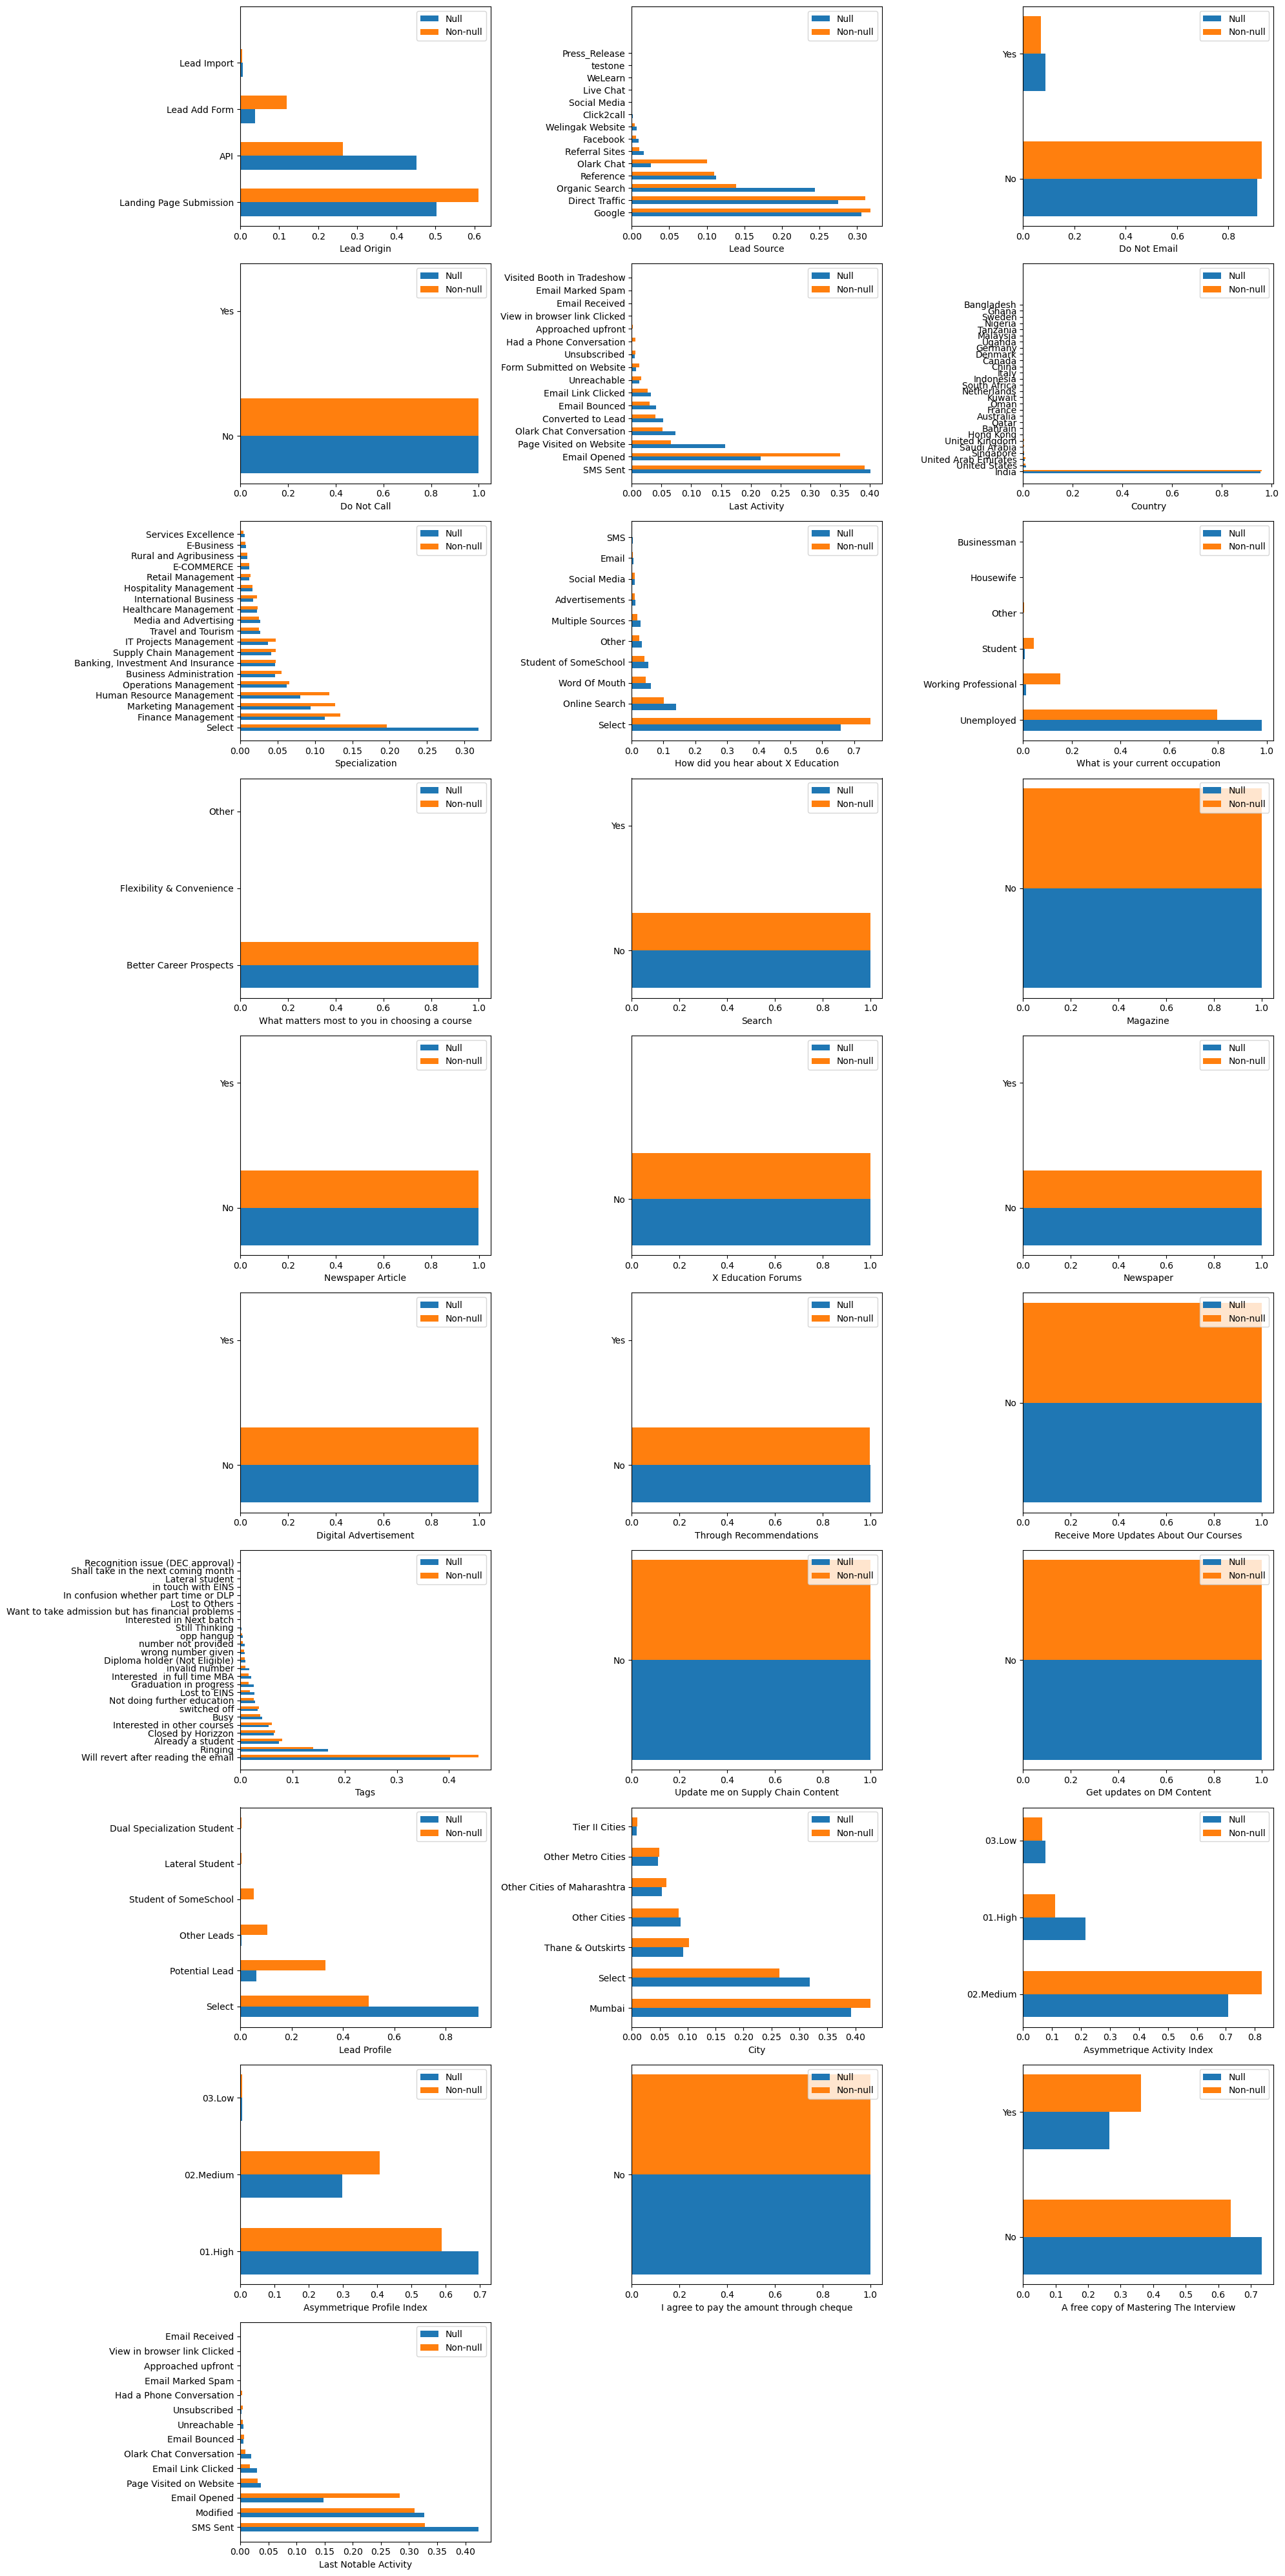

In [12]:
# Exploring patterns of category feature distribution between nulls and non_nulls of Lead Quality
df1 = data[data['Lead Quality'].isnull()]
df2 = data[~data['Lead Quality'].isnull()]
catcols = data.drop(['Lead Quality', 'Prospect ID'], axis=1).select_dtypes(include= 'O').columns

value_count_plots([df1, df2], catcols, ['Null', 'Non-null'], [20, 40])

In [13]:
# Visitors who have not selected any course type and/or not assigned tags have higher null values of Lead Quality
# Organic Search, Webpage visited has higher null values in Lead Quality
# Email opened, Olark Chat in Last or Last Notable activity category have higher non-null values in Lead Quality
# Working professional and Students have more non-null values in Lead Quality

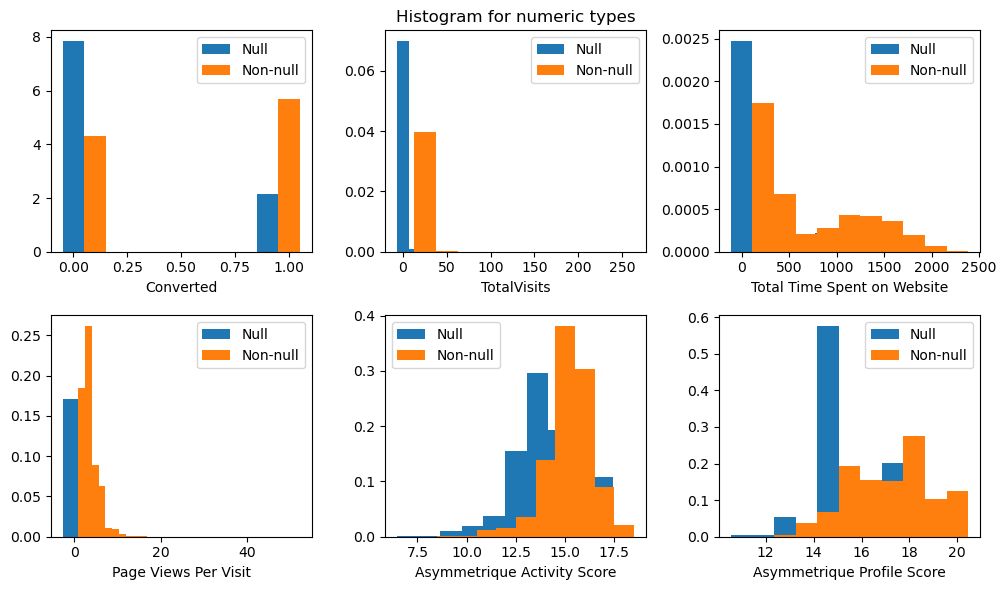

In [14]:
# Exploring patterns of numeric feature distribution for nulls and non-nulls of Lead Quallity
df1 = data[data['Lead Quality'].isnull()]
df2 = data[~data['Lead Quality'].isnull()]
numcols = data.drop('Lead Number', axis=1).select_dtypes(include = np.number).columns

histogram_plots([df1, df2], numcols, ['Null', 'Non-null'], [10, 6])

In [15]:
# Non-null values of Lead Quality has higher conversion than nulls
# Asummetrique Profile score for null Lead Quality lies between 14-15
# Nulls have a higher Total Visits and Total Time Spent on webpage than non-nulls

In [16]:
''''
Observations:
So it is possible from the above observation that null values have a higher non-response bias. But it still generates
    positive network traffic for webpage. Lead Quality is assigned by sales personnel based on their perception of future
    conversion. Those having null values have not been touch based by any sales personnel. So these spurious visits may be
    caused by bots on the internet. Or the sales personnel may be ignoring prospects who have not mentioned course
    preference, and/or if the system has not assigned any lead profile.
'''

"'\nObservations:\nSo it is possible from the above observation that null values have a higher non-response bias. But it still generates\n    positive network traffic for webpage. Lead Quality is assigned by sales personnel based on their perception of future\n    conversion. Those having null values have not been touch based by any sales personnel. So these spurious visits may be\n    caused by bots on the internet. Or the sales personnel may be ignoring prospects who have not mentioned course\n    preference, and/or if the system has not assigned any lead profile.\n"

In [17]:
# Impute value as Lead Quality is correlated to lead conversion
data['Lead Quality'].fillna('Not Sure', inplace=True)

In [18]:
# Dropping Asymmetrique-related columns due to high missingness
asym_cols = ['Asymmetrique Activity Index', 'Asymmetrique Profile Score',
             'Asymmetrique Activity Score', 'Asymmetrique Profile Index']

# Missing asymmetrique type columns have the same index
np.all(data[asym_cols[1]].index == data[asym_cols[2]].index)

True

In [19]:
# Checking for correlation between asymmetrique score features
# Values have a weak inverse correlation
asmScore_cols = data[asym_cols].columns[data[asym_cols].dtypes != 'O']
data[asmScore_cols].corr()

Asymmetrique Profile Score  \
Asymmetrique Profile Score                      1.00000   
Asymmetrique Activity Score                    -0.12325   

                             Asymmetrique Activity Score  
Asymmetrique Profile Score                      -0.12325  
Asymmetrique Activity Score                      1.00000

In [20]:
# Linear combination of standardized asymmetrique scores using equal weightage
act_coeff = 1
prof_coeff = 1
Profile_Activity_Score = np.array([coef * (data[col] - data[col].mean())/data[col].std() 
                                   for col, coef in zip(asmScore_cols, [act_coeff, prof_coeff])]).sum(axis=0)

In [21]:
# Dropping asymmetrique columns and adding linear combination of scores
data.drop(asym_cols, axis=1, inplace=True)
data['Profile Activity Score'] = Profile_Activity_Score

In [22]:
# Since Activity and Profile scores are generated from the dataset itself, 
#   the data for the non-null values can be used to train and predict the null values. 
#   A decision tree is used because it can work with null values in its design matrix 
#   and it will not introduce any linearity in the dataset

# Target columns is dropped from this prediction to eliminate model bias due to backpropagation

In [23]:
# segregating null and non_null Profile Activity scores
ls_nullScore = data[data['Profile Activity Score'].isnull()]
ls_nonNullScore = data[~data['Profile Activity Score'].isnull()]

In [24]:
# Dropping target feature
ls_nullScore.drop(columns='Converted', inplace= True)
ls_nonNullScore.drop(columns='Converted', inplace= True)

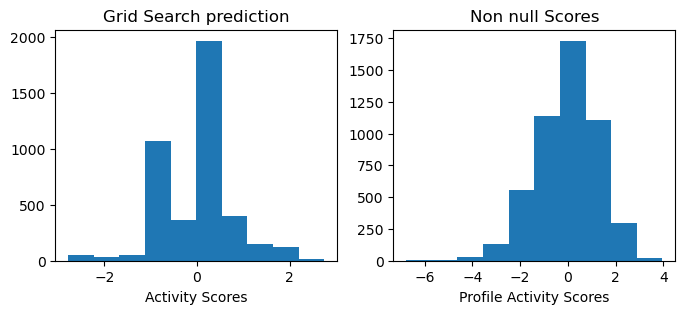

In [25]:
# using decision tree for predicting null values
cols = ls_nonNullScore.columns[ls_nonNullScore.dtypes == 'O']
encoder = OrdinalEncoder()
# encoding category features
ls_nonNullScore[cols] = encoder.fit_transform(ls_nonNullScore[cols])

X = ls_nonNullScore.drop(columns= 'Profile Activity Score')
y = ls_nonNullScore['Profile Activity Score']

dt= DecisionTreeRegressor(criterion='squared_error')
params = {
    'max_depth': np.arange(2, 21),
    'min_samples_leaf': np.arange(2, 50),
    }
grid = GridSearchCV(estimator= dt, param_grid= params, cv= 3, n_jobs= -1)
grid.fit(X, y)

# encoding for category features for nulls of Profile_Activity_Score
ls_nullScore[cols] = encoder.fit_transform(ls_nullScore[cols])
X = ls_nullScore.drop(columns= 'Profile Activity Score')

null_scores_grid = grid.best_estimator_.predict(X)   # gridsearch model

# plotting distributions
plt.figure(figsize=(8, 3))
ax2 = plt.subplot(1, 2, 1)
ax2.hist(null_scores_grid)
ax2.set_xlabel('Activity Scores')
ax2.set_title('Grid Search prediction')

ax3 = plt.subplot(1, 2, 2)
ax3.hist(ls_nonNullScore['Profile Activity Score'])
ax3.set_xlabel('Profile Activity Scores')
ax3.set_title('Non null Scores')
plt.show()

In [26]:
# Plugging back values
data.loc[data['Profile Activity Score'].isnull(), 'Profile Activity Score'] = null_scores_grid

In [27]:
# Impute 'Last Activity' and 'Lead Source' with mode
data['Last Activity'].fillna(data['Last Activity'].mode()[0], inplace=True)
data['Lead Source'].fillna(data['Lead Source'].mode()[0], inplace=True)

In [28]:
### Handling Other Missing Values

In [29]:
# Imputing categorical columns with 'Unknown'

In [30]:
categorical_cols = ['Tags', 'Lead Profile', 'What matters most to you in choosing a course',
                    'What is your current occupation', 'Country', 'How did you hear about X Education',
                    'Specialization', 'City']

In [31]:
for col in categorical_cols:
    data[col].fillna('Unknown', inplace=True)

In [32]:
# Imputing numerical columns with median
numerical_cols = ['Page Views Per Visit', 'TotalVisits']
for col in numerical_cols:
    data[col].fillna(data[col].median(), inplace=True)

In [33]:
### verify the missing values

In [34]:
# Checking for missing values
missing_values = data.isnull().sum().sort_values(ascending=False)
print("Missing Values:\n", missing_values)

Missing Values:
 Prospect ID                                      0
Lead Quality                                     0
X Education Forums                               0
Newspaper                                        0
Digital Advertisement                            0
Through Recommendations                          0
Receive More Updates About Our Courses           0
Tags                                             0
Update me on Supply Chain Content                0
Lead Number                                      0
Get updates on DM Content                        0
Lead Profile                                     0
City                                             0
I agree to pay the amount through cheque         0
A free copy of Mastering The Interview           0
Last Notable Activity                            0
Newspaper Article                                0
Magazine                                         0
Search                                           0
What matters m

In [35]:
data.shape

(9240, 34)

In [36]:
### Removing Duplicates
data.drop_duplicates(inplace=True)

In [37]:
data.shape

(9240, 34)

In [38]:
## 4. Exploratory Data Analysis (EDA)

In [39]:
# Univariate analysis: Category features

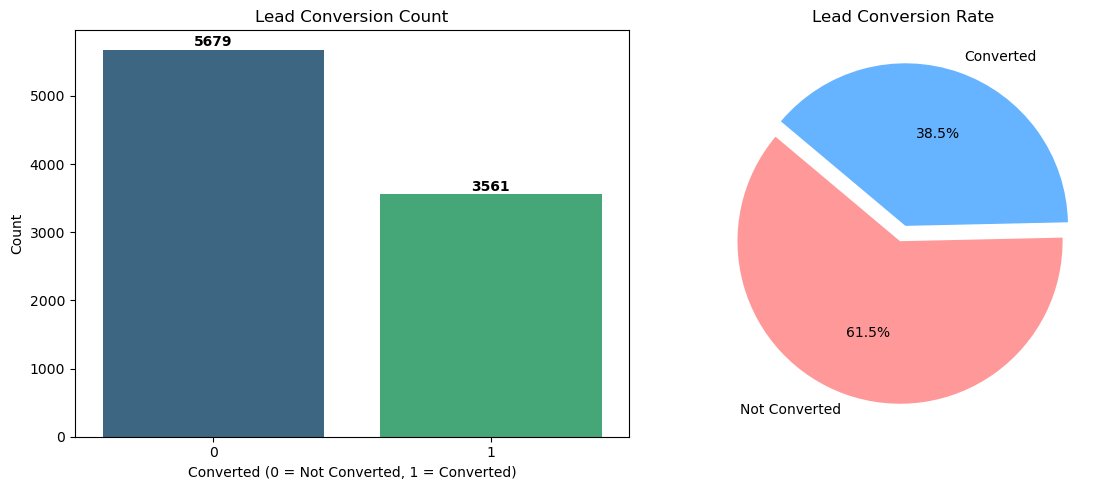

In [40]:
### Conversion Rate (Count Plot and Pie Chart Side by Side)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Count Plot
sns.countplot(x='Converted', data=data, palette='viridis', ax=axes[0])
axes[0].set_title('Lead Conversion Count')
axes[0].set_xlabel('Converted (0 = Not Converted, 1 = Converted)')
axes[0].set_ylabel('Count')
for index, value in enumerate(data['Converted'].value_counts()):
    axes[0].text(index, value + 50, str(value), ha='center', fontweight='bold')

# Pie Chart
sizes = data['Converted'].value_counts()
labels = ['Not Converted', 'Converted']
colors = ['#ff9999', '#66b3ff']
explode = (0.05, 0.05)
axes[1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode)
axes[1].set_title('Lead Conversion Rate')

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

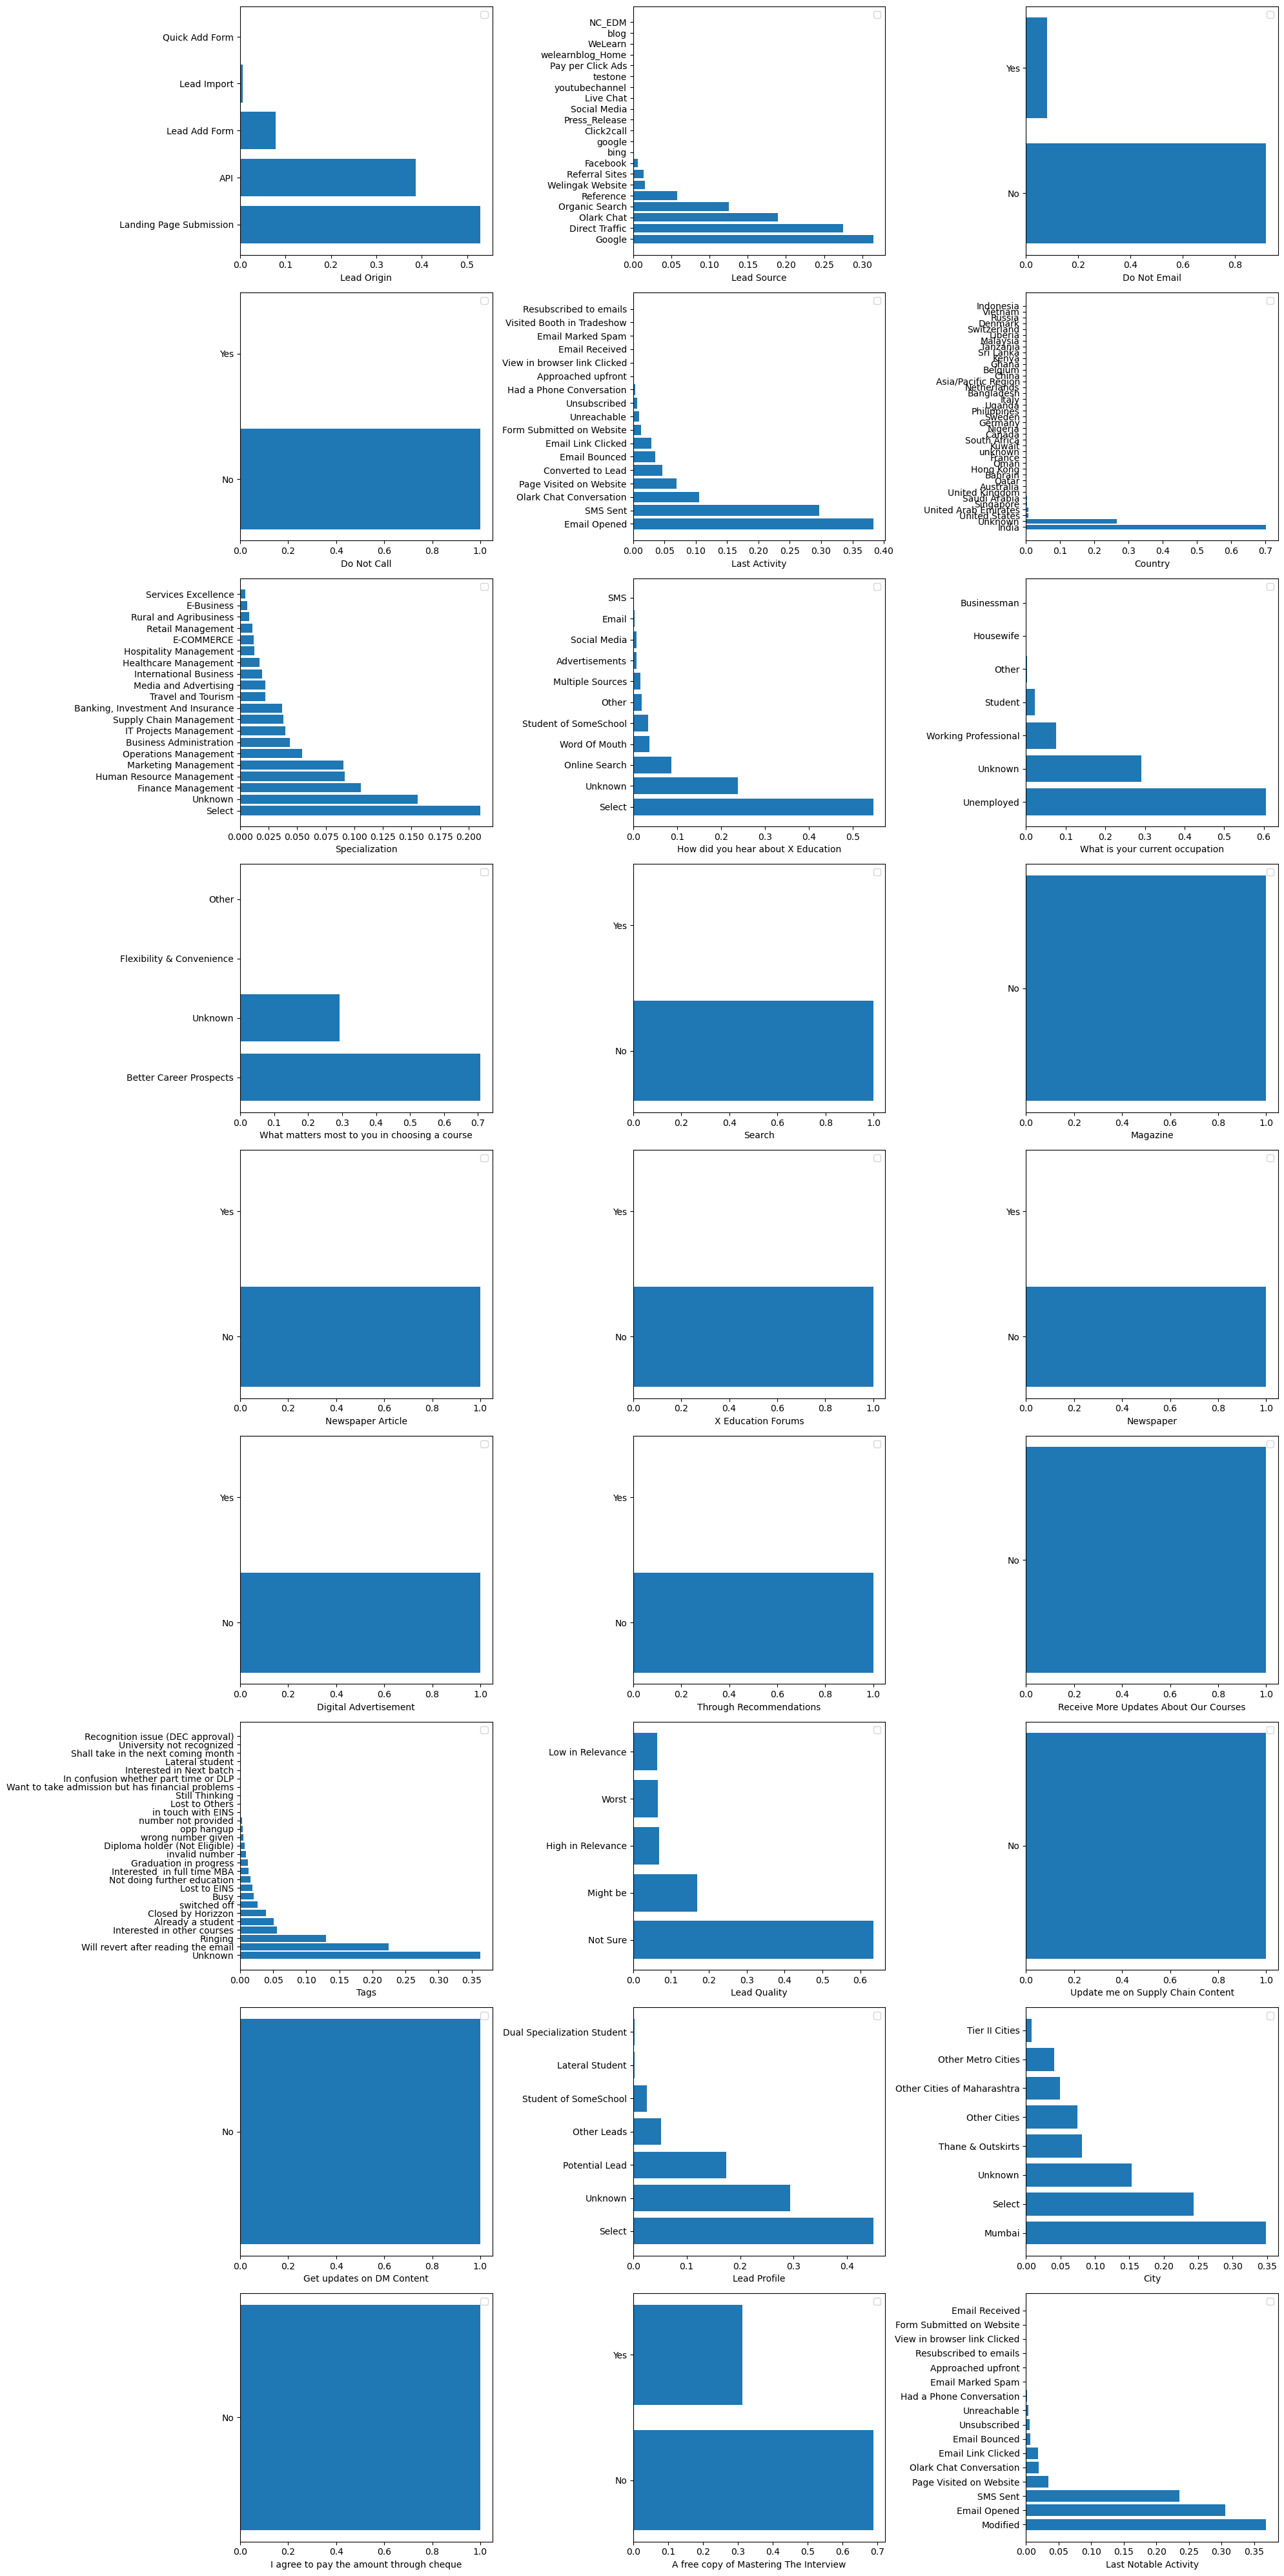

In [41]:
### Distribution of Categorical Features
# Get the categorical columns
categorical_columns = data.select_dtypes(include=['object', 'category']).columns.drop('Prospect ID')

value_count_plots(data, categorical_columns, size=(20, 40), ncols= 3)

In [42]:
# There are some unary features which can be dropped later

In [43]:
# Univariate analysis: Numeric features

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


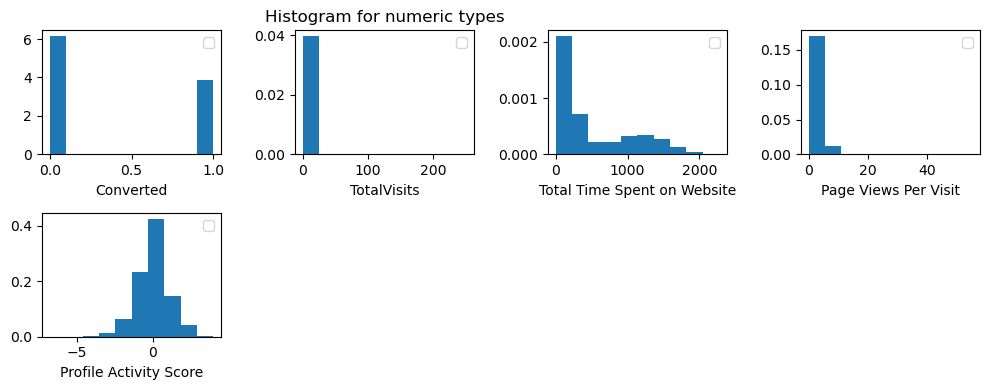

In [44]:
# Distribution of values pf numeric features
numerical_cols = data.select_dtypes(include=np.number).columns.drop('Lead Number')

histogram_plots(data, numerical_cols, size=(10, 4), ncols= 4)

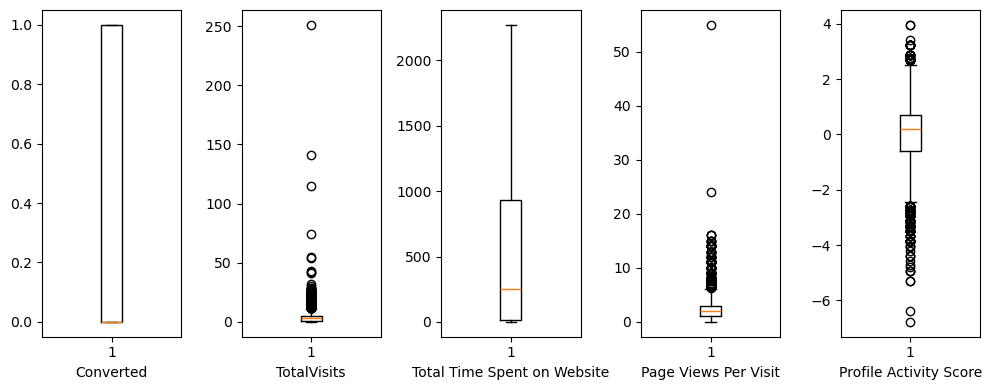

In [45]:
# Spread of values of numeric features
box_plots(data, numerical_cols, size=(10, 4), ncols= 5)

In [46]:
# Outlier treatment for numeric features
for col in numerical_cols:
    data[col] = cap_outlier(data[col])

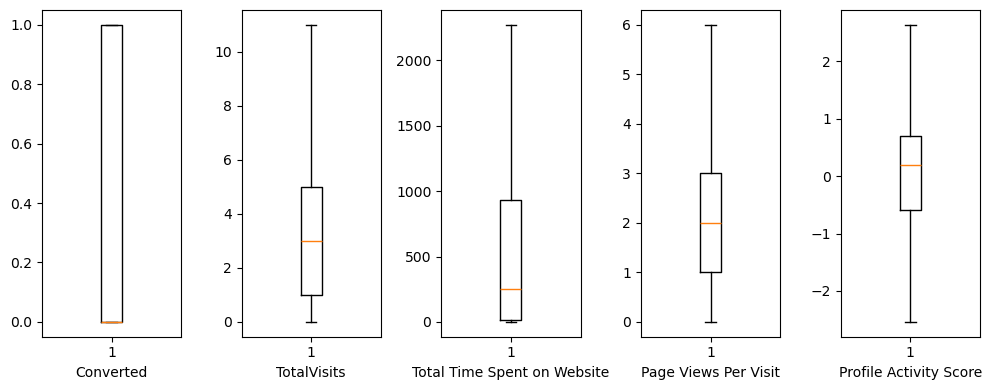

In [47]:
# Rechecking spread of data
box_plots(data, numerical_cols, size=(10, 4), ncols= 5)

In [48]:
# Bivariate analysis: Numeric vs category features

In [49]:
categorical_cols

['Tags',
 'Lead Profile',
 'What matters most to you in choosing a course',
 'What is your current occupation',
 'Country',
 'How did you hear about X Education',
 'Specialization',
 'City']

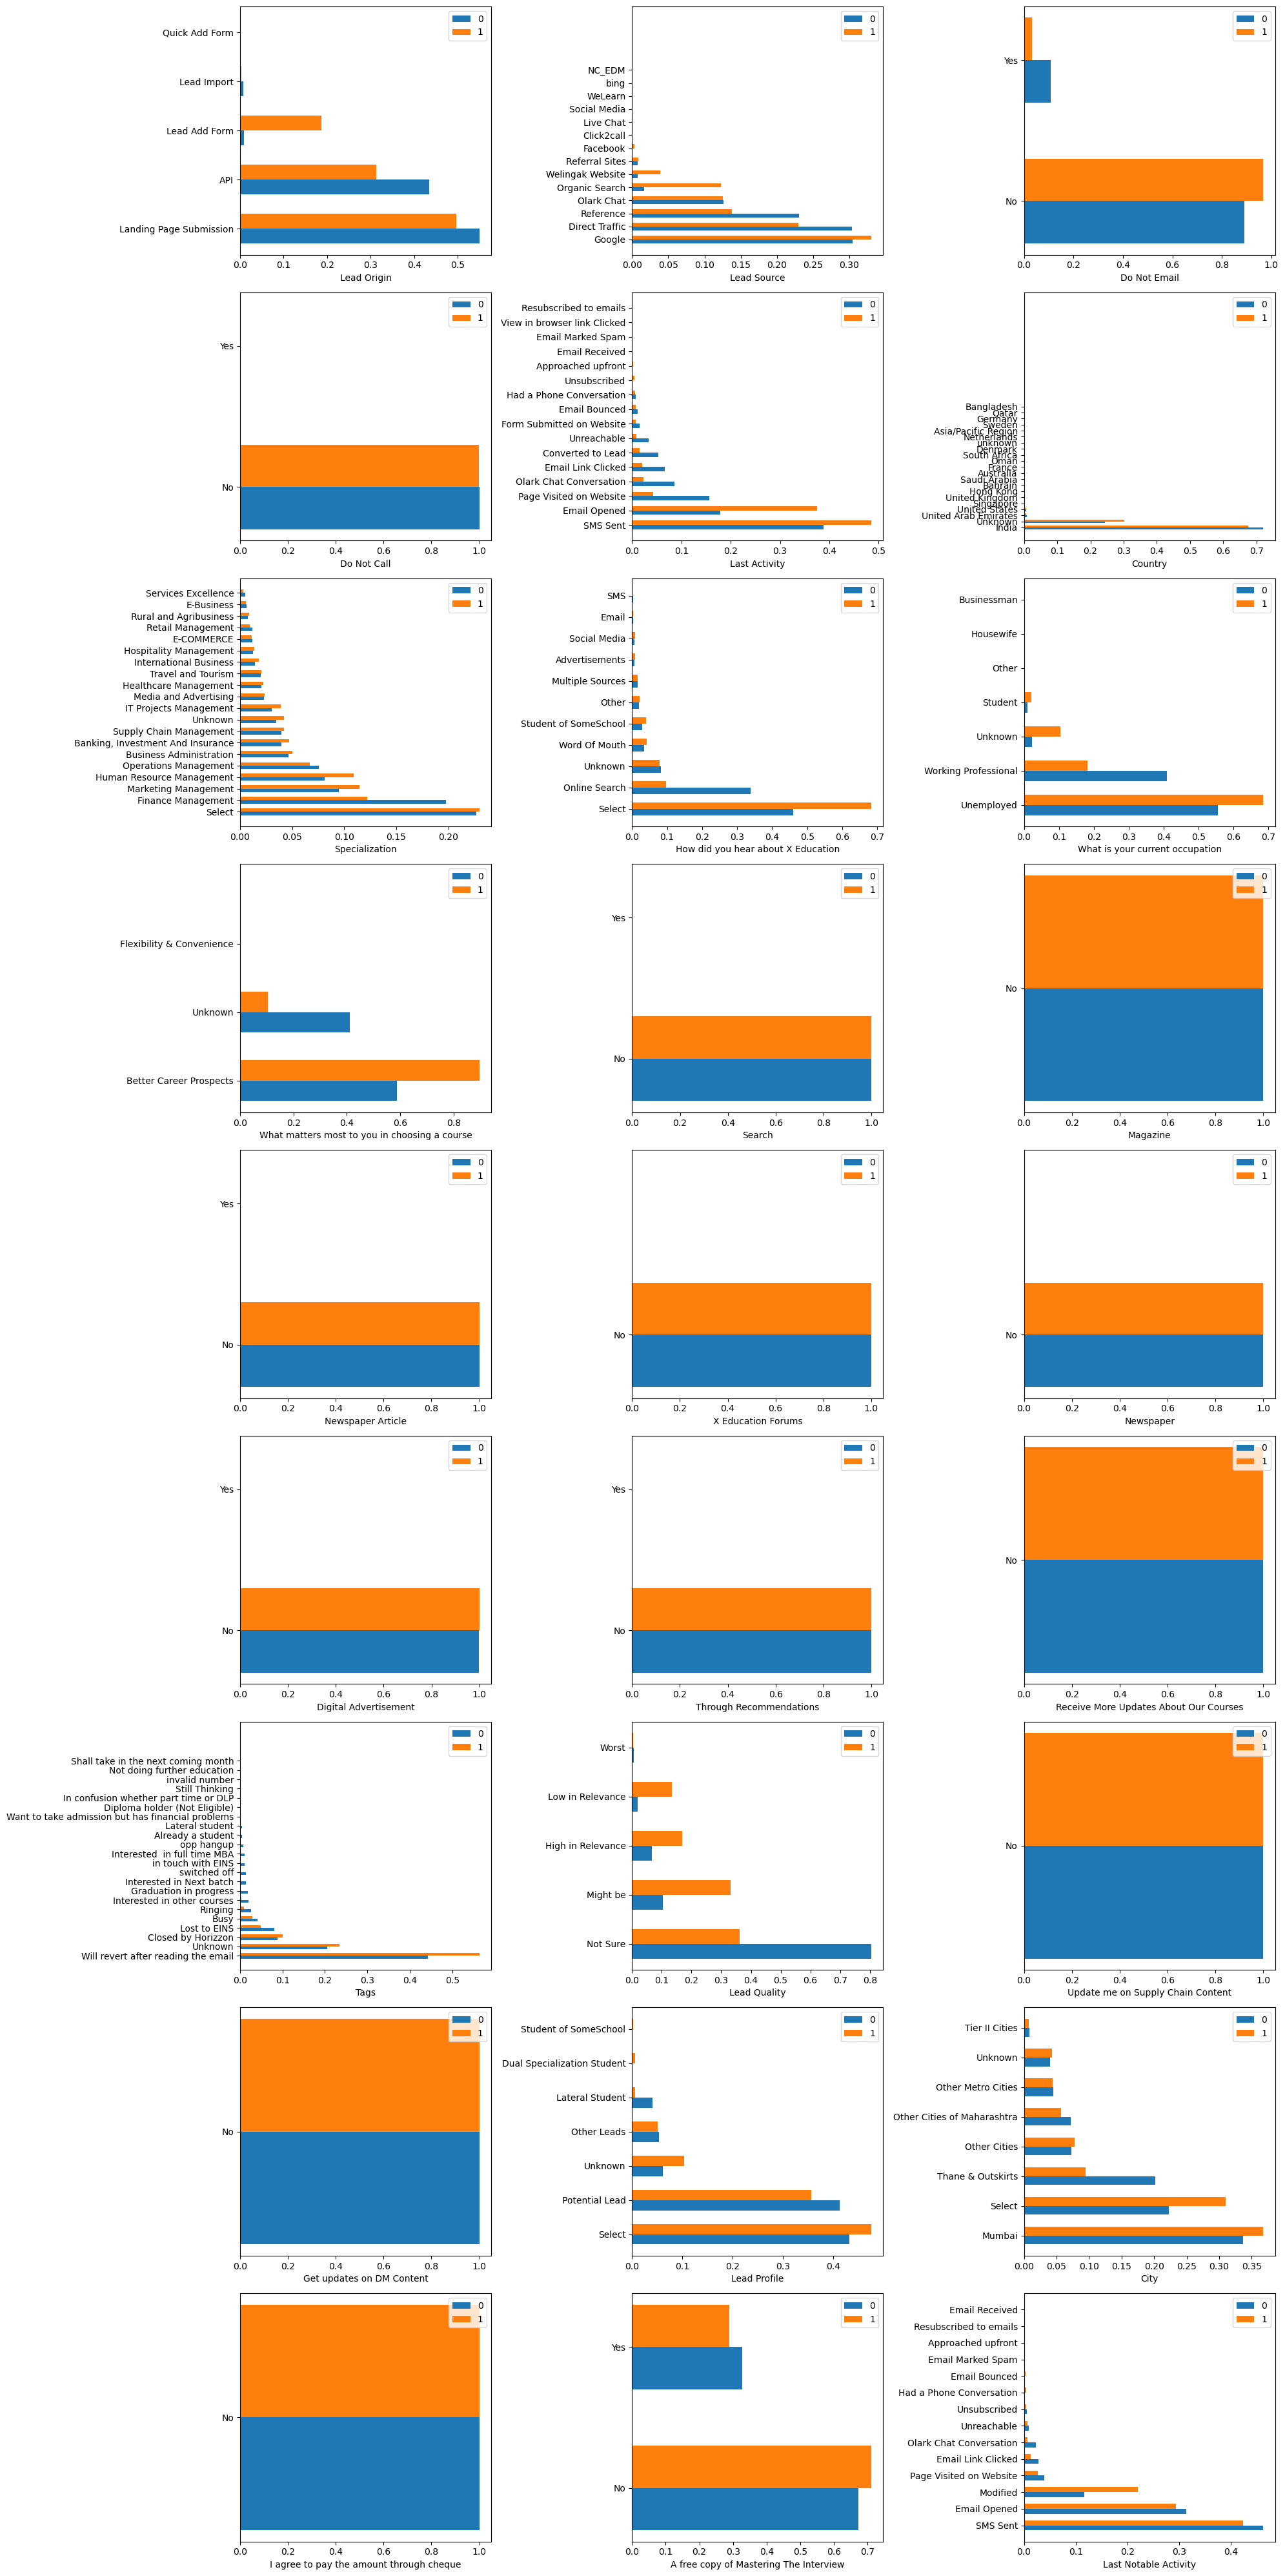

In [50]:
# Distribution of target across unique values of each category feature
df1 = data[data.Converted == 0]
df2 = data[data.Converted == 1]
cols = data.select_dtypes(include= 'O').columns.drop('Prospect ID')

value_count_plots(dfs = [df1, df2], labels=[0, 1], columns= cols, size=(20, 40))

In [51]:
# Spread of Target feature across all category features
catcols = data.select_dtypes(include= 'O').columns.drop('Prospect ID')
numcols = data.select_dtypes(include= np.number).columns.drop('Lead Number')
numcols

Index(['Converted', 'TotalVisits', 'Total Time Spent on Website',
       'Page Views Per Visit', 'Profile Activity Score'],
      dtype='object')

Converted


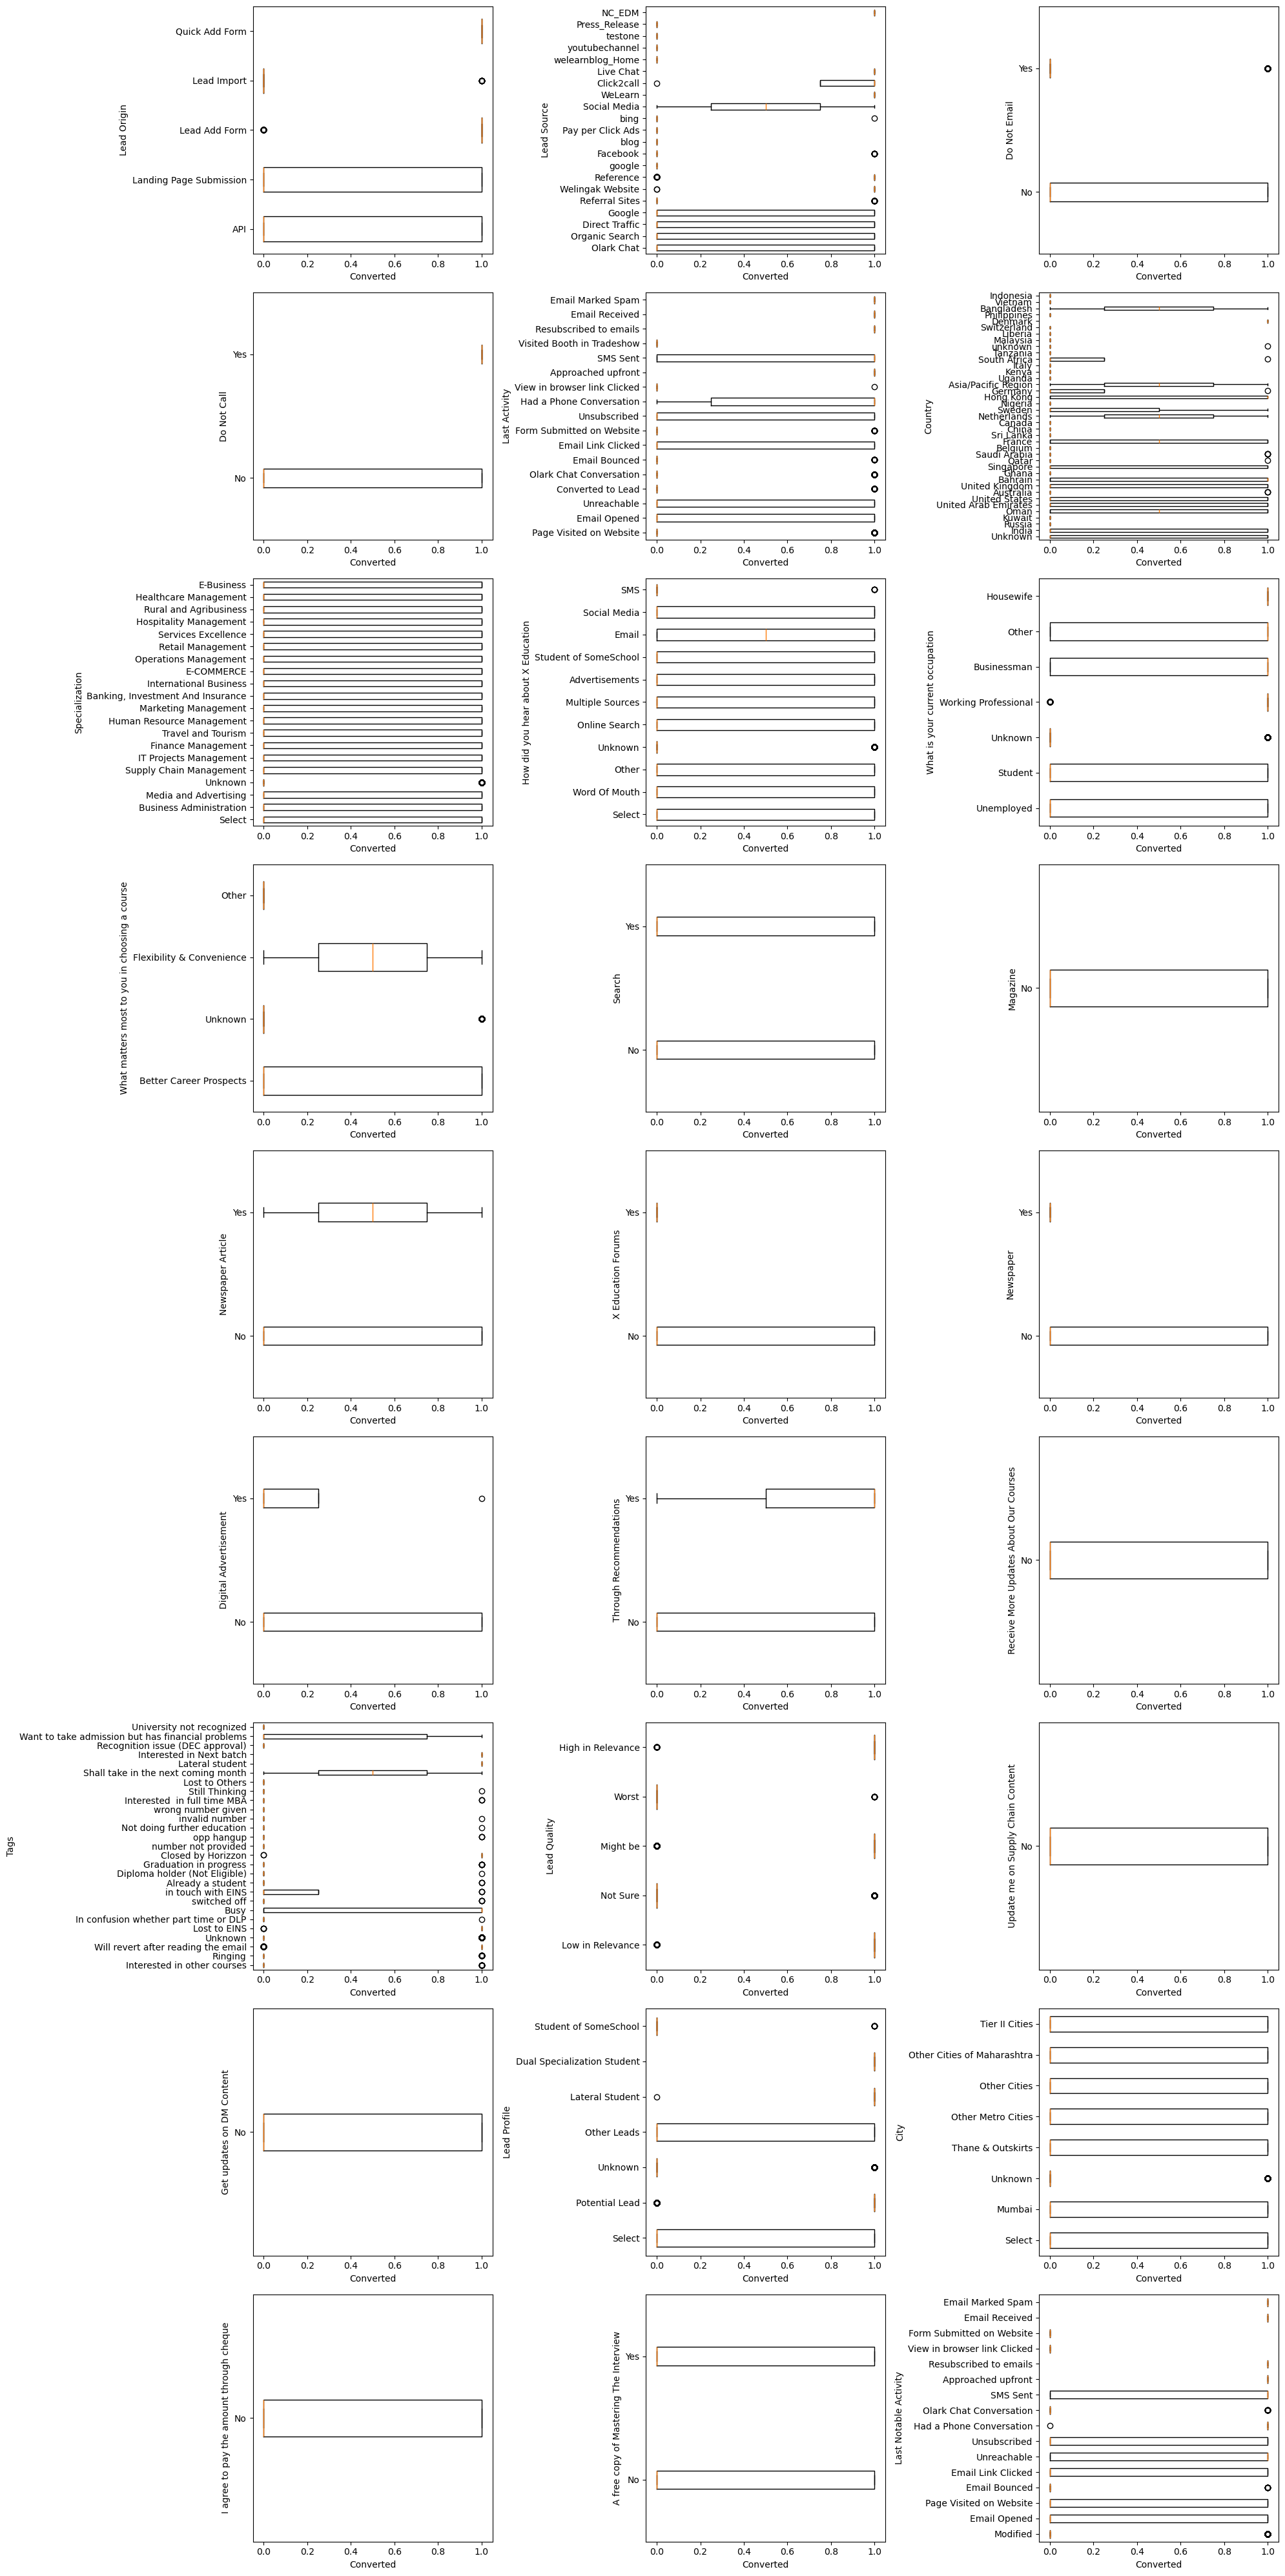

TotalVisits


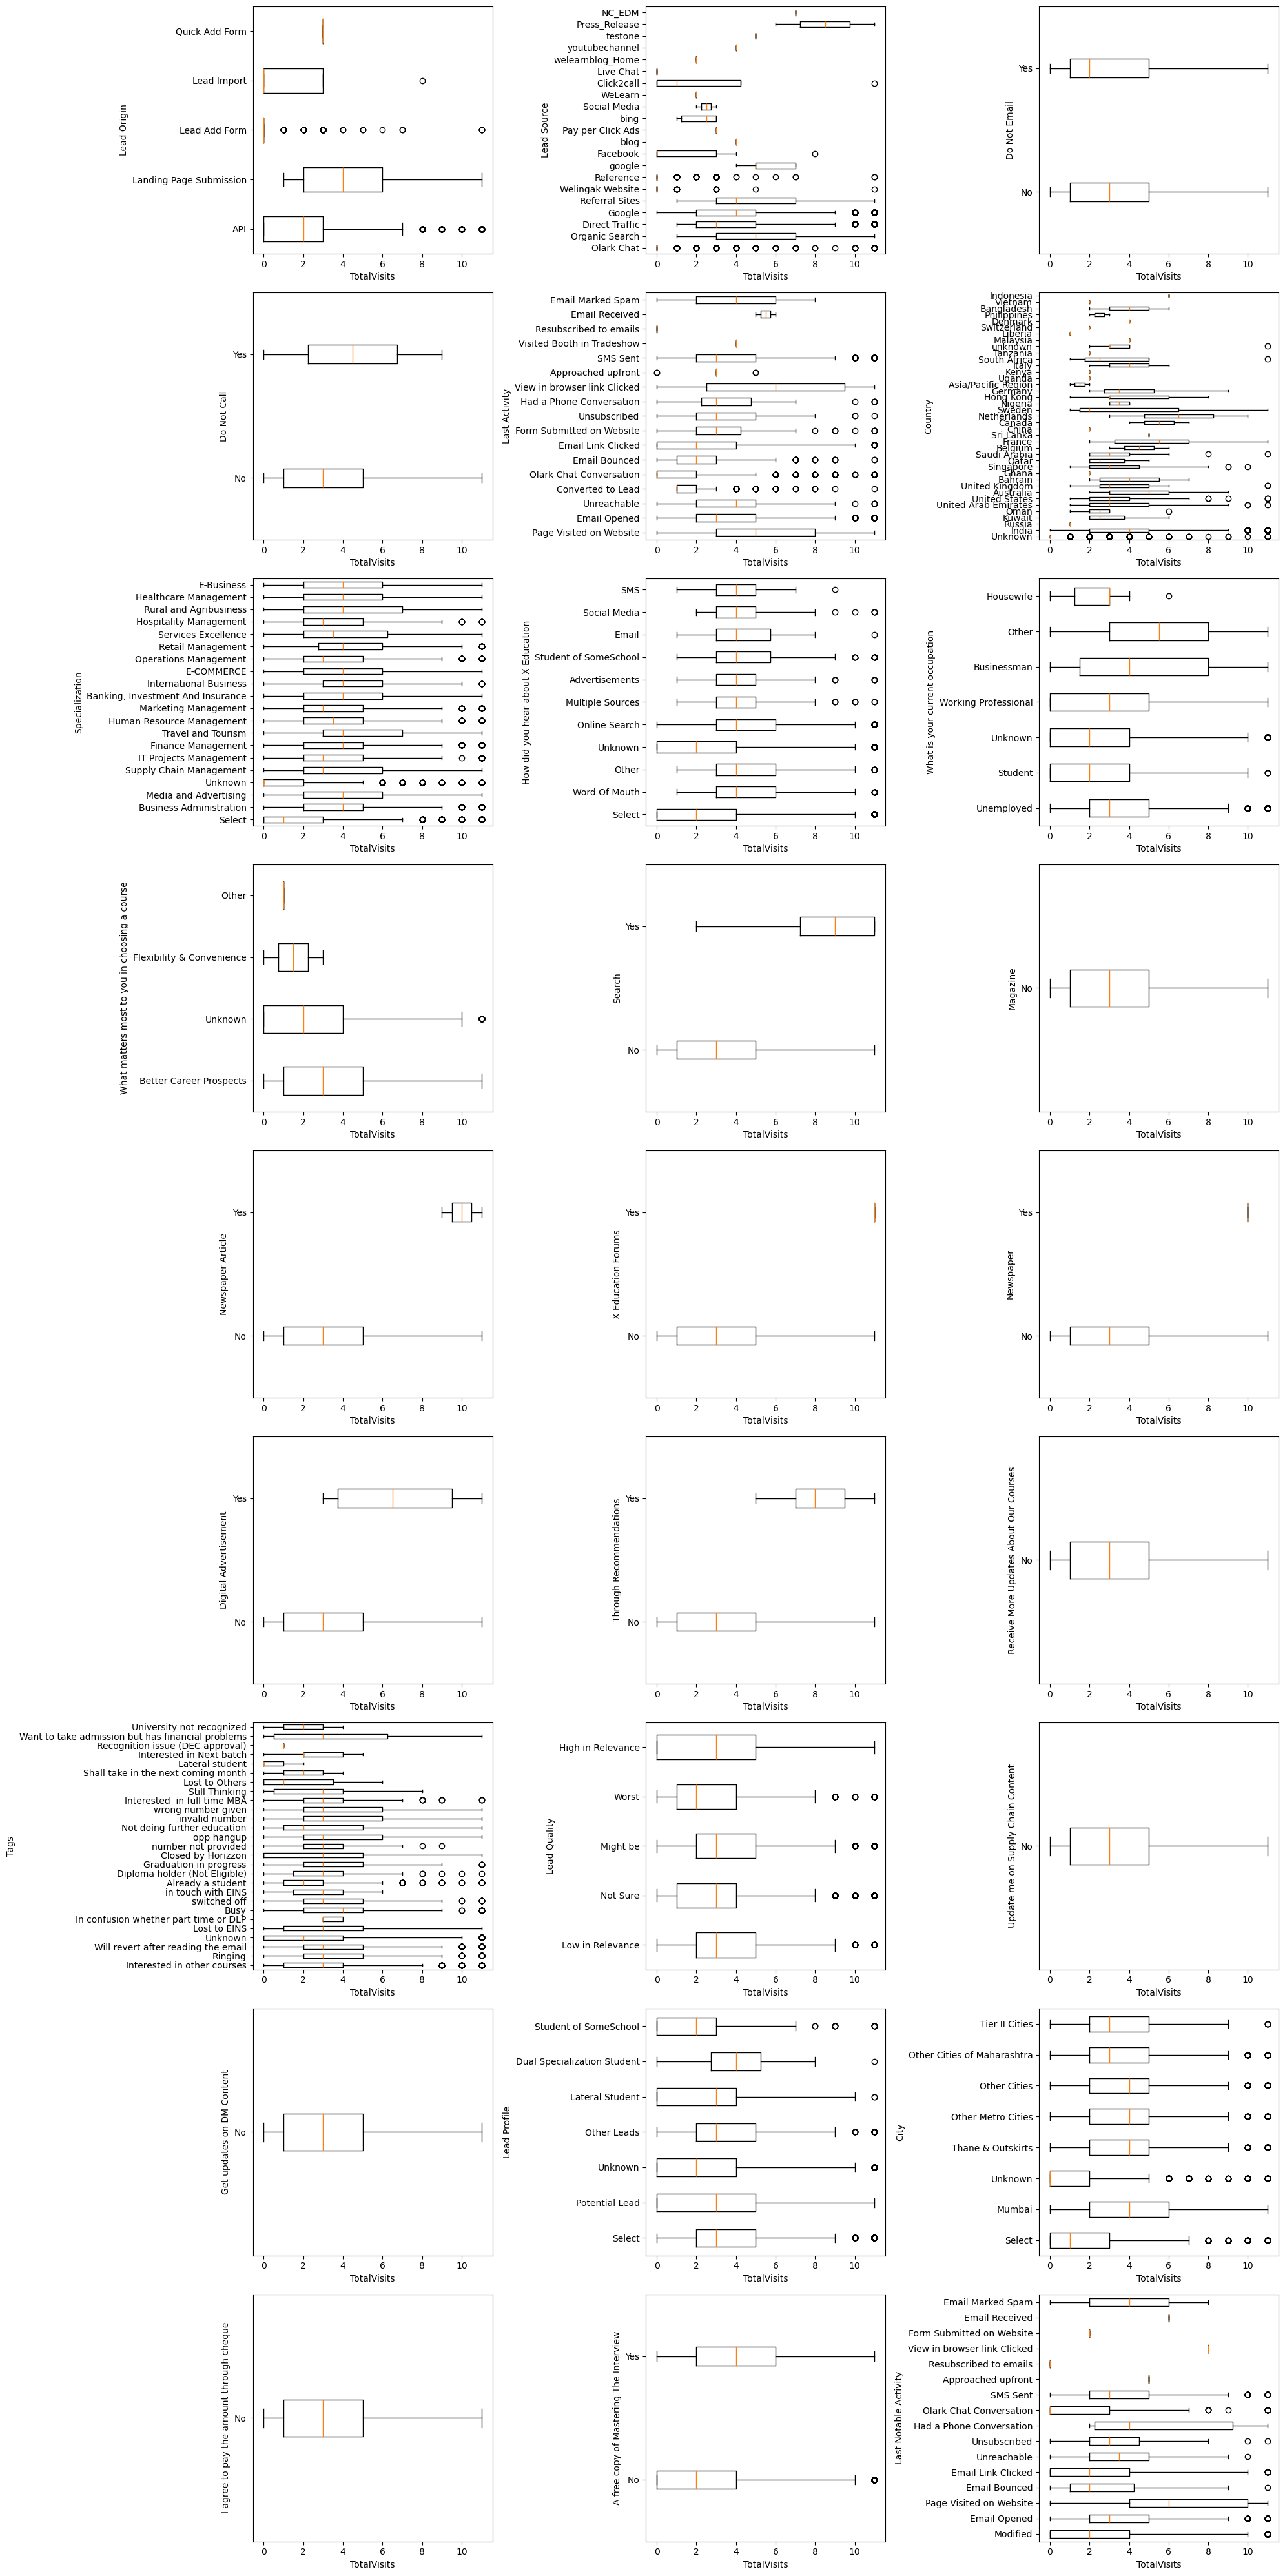

Total Time Spent on Website


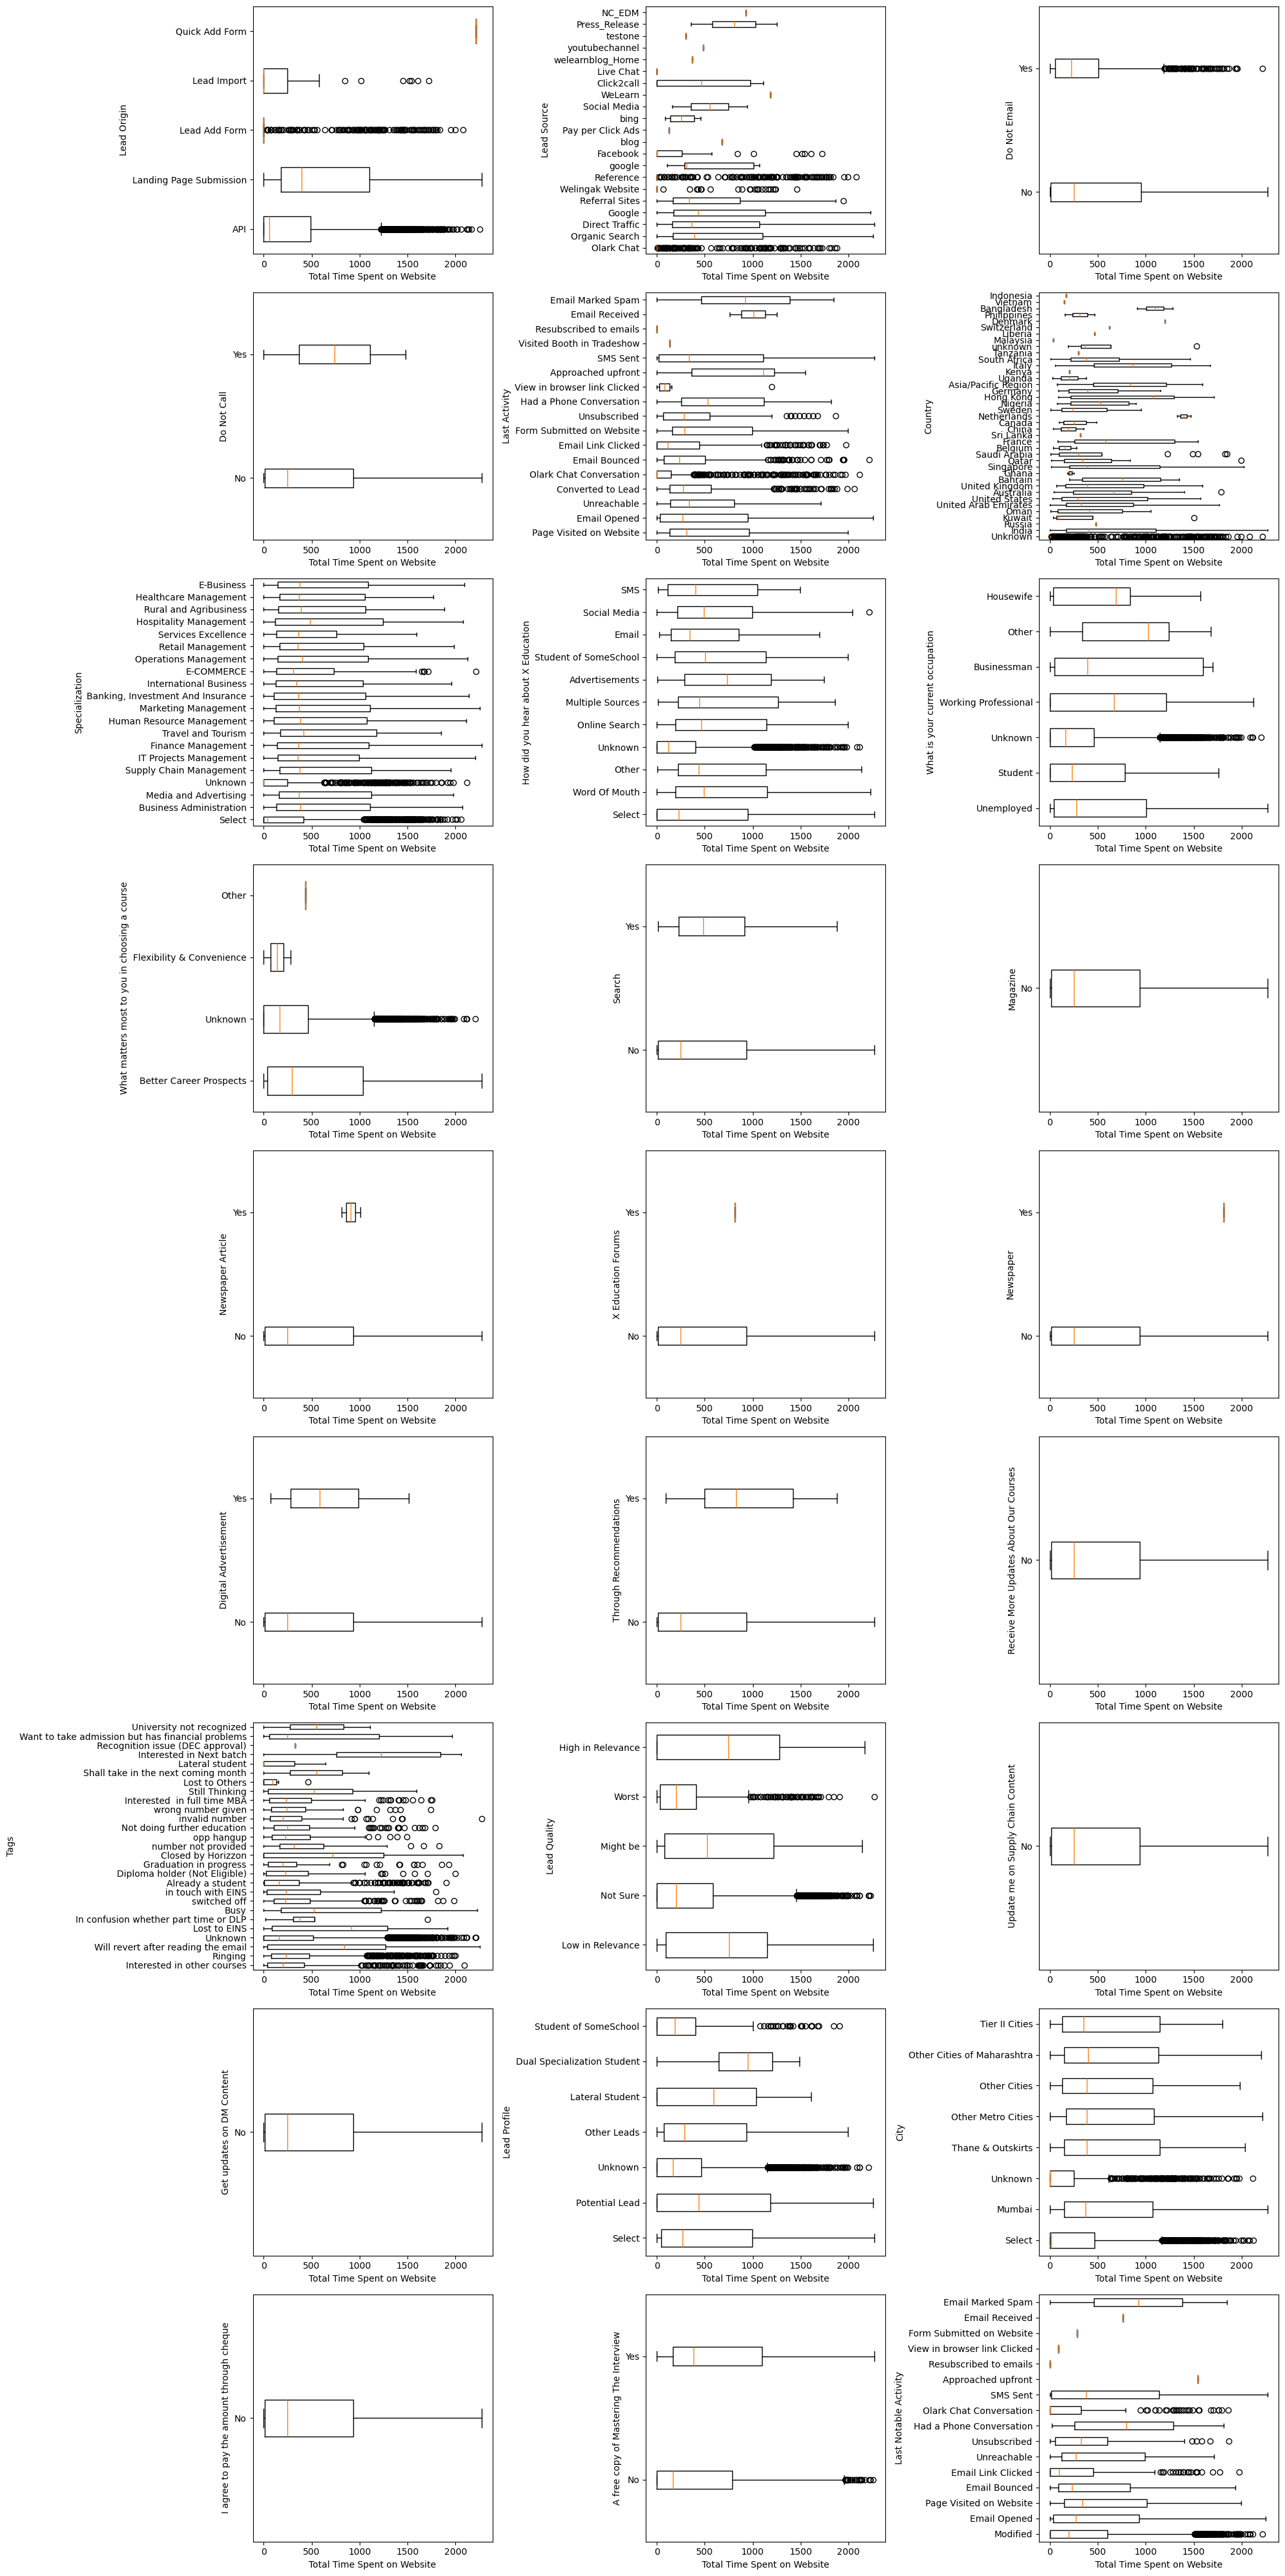

Page Views Per Visit


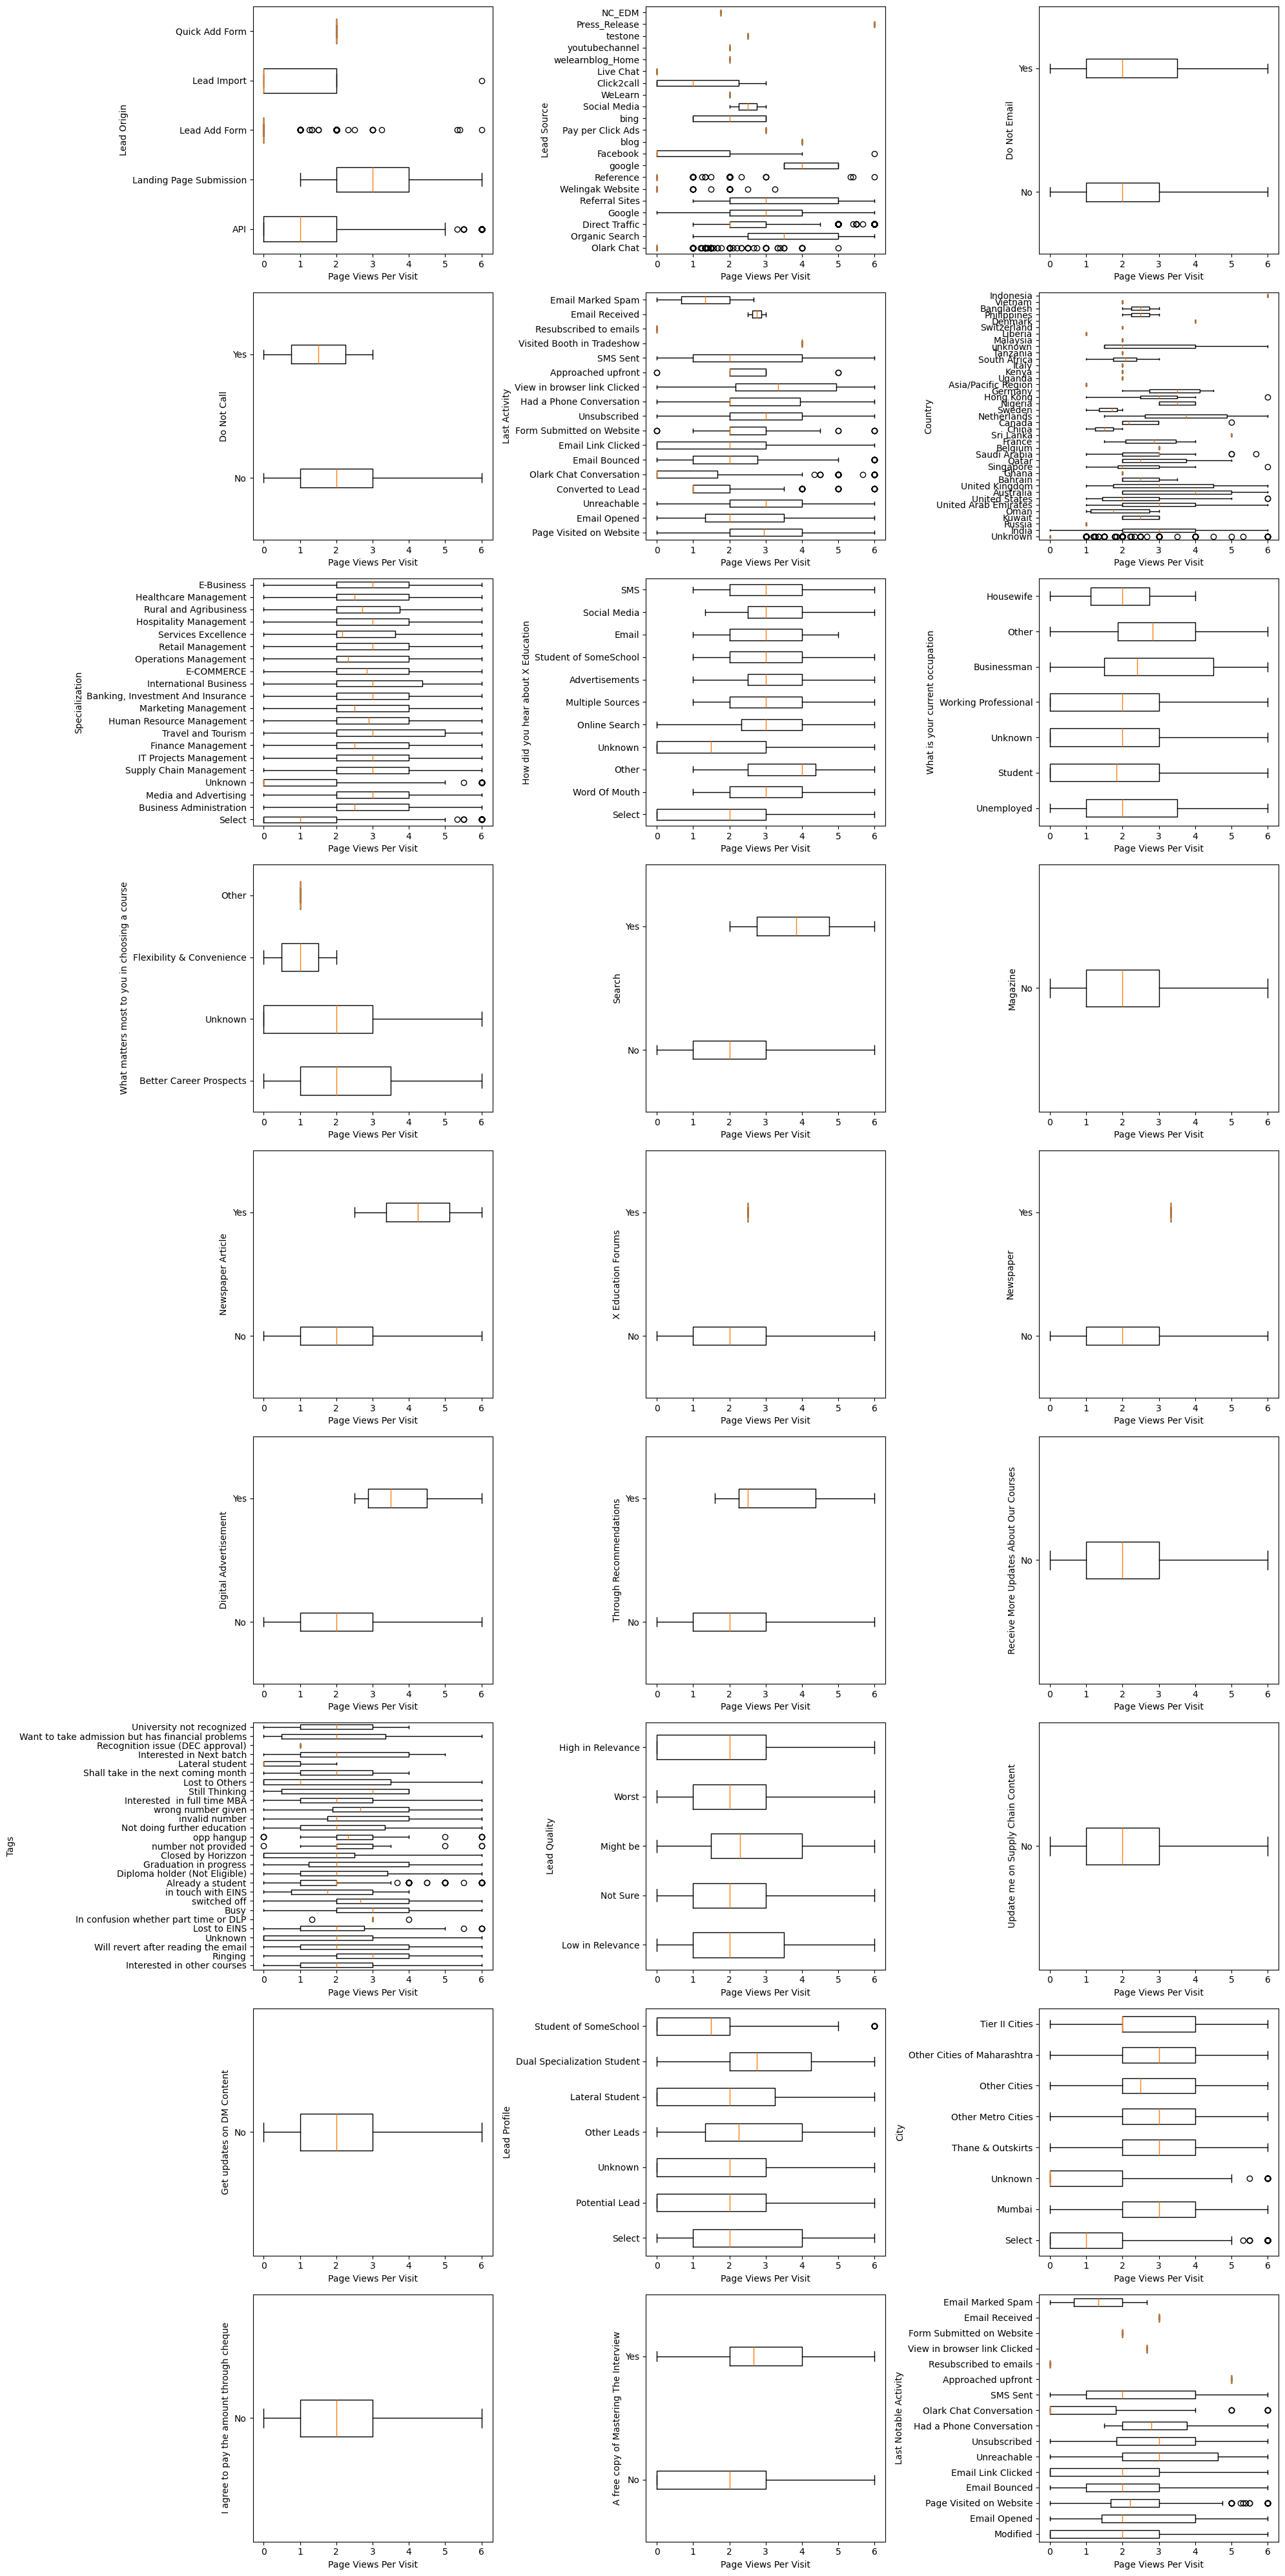

Profile Activity Score


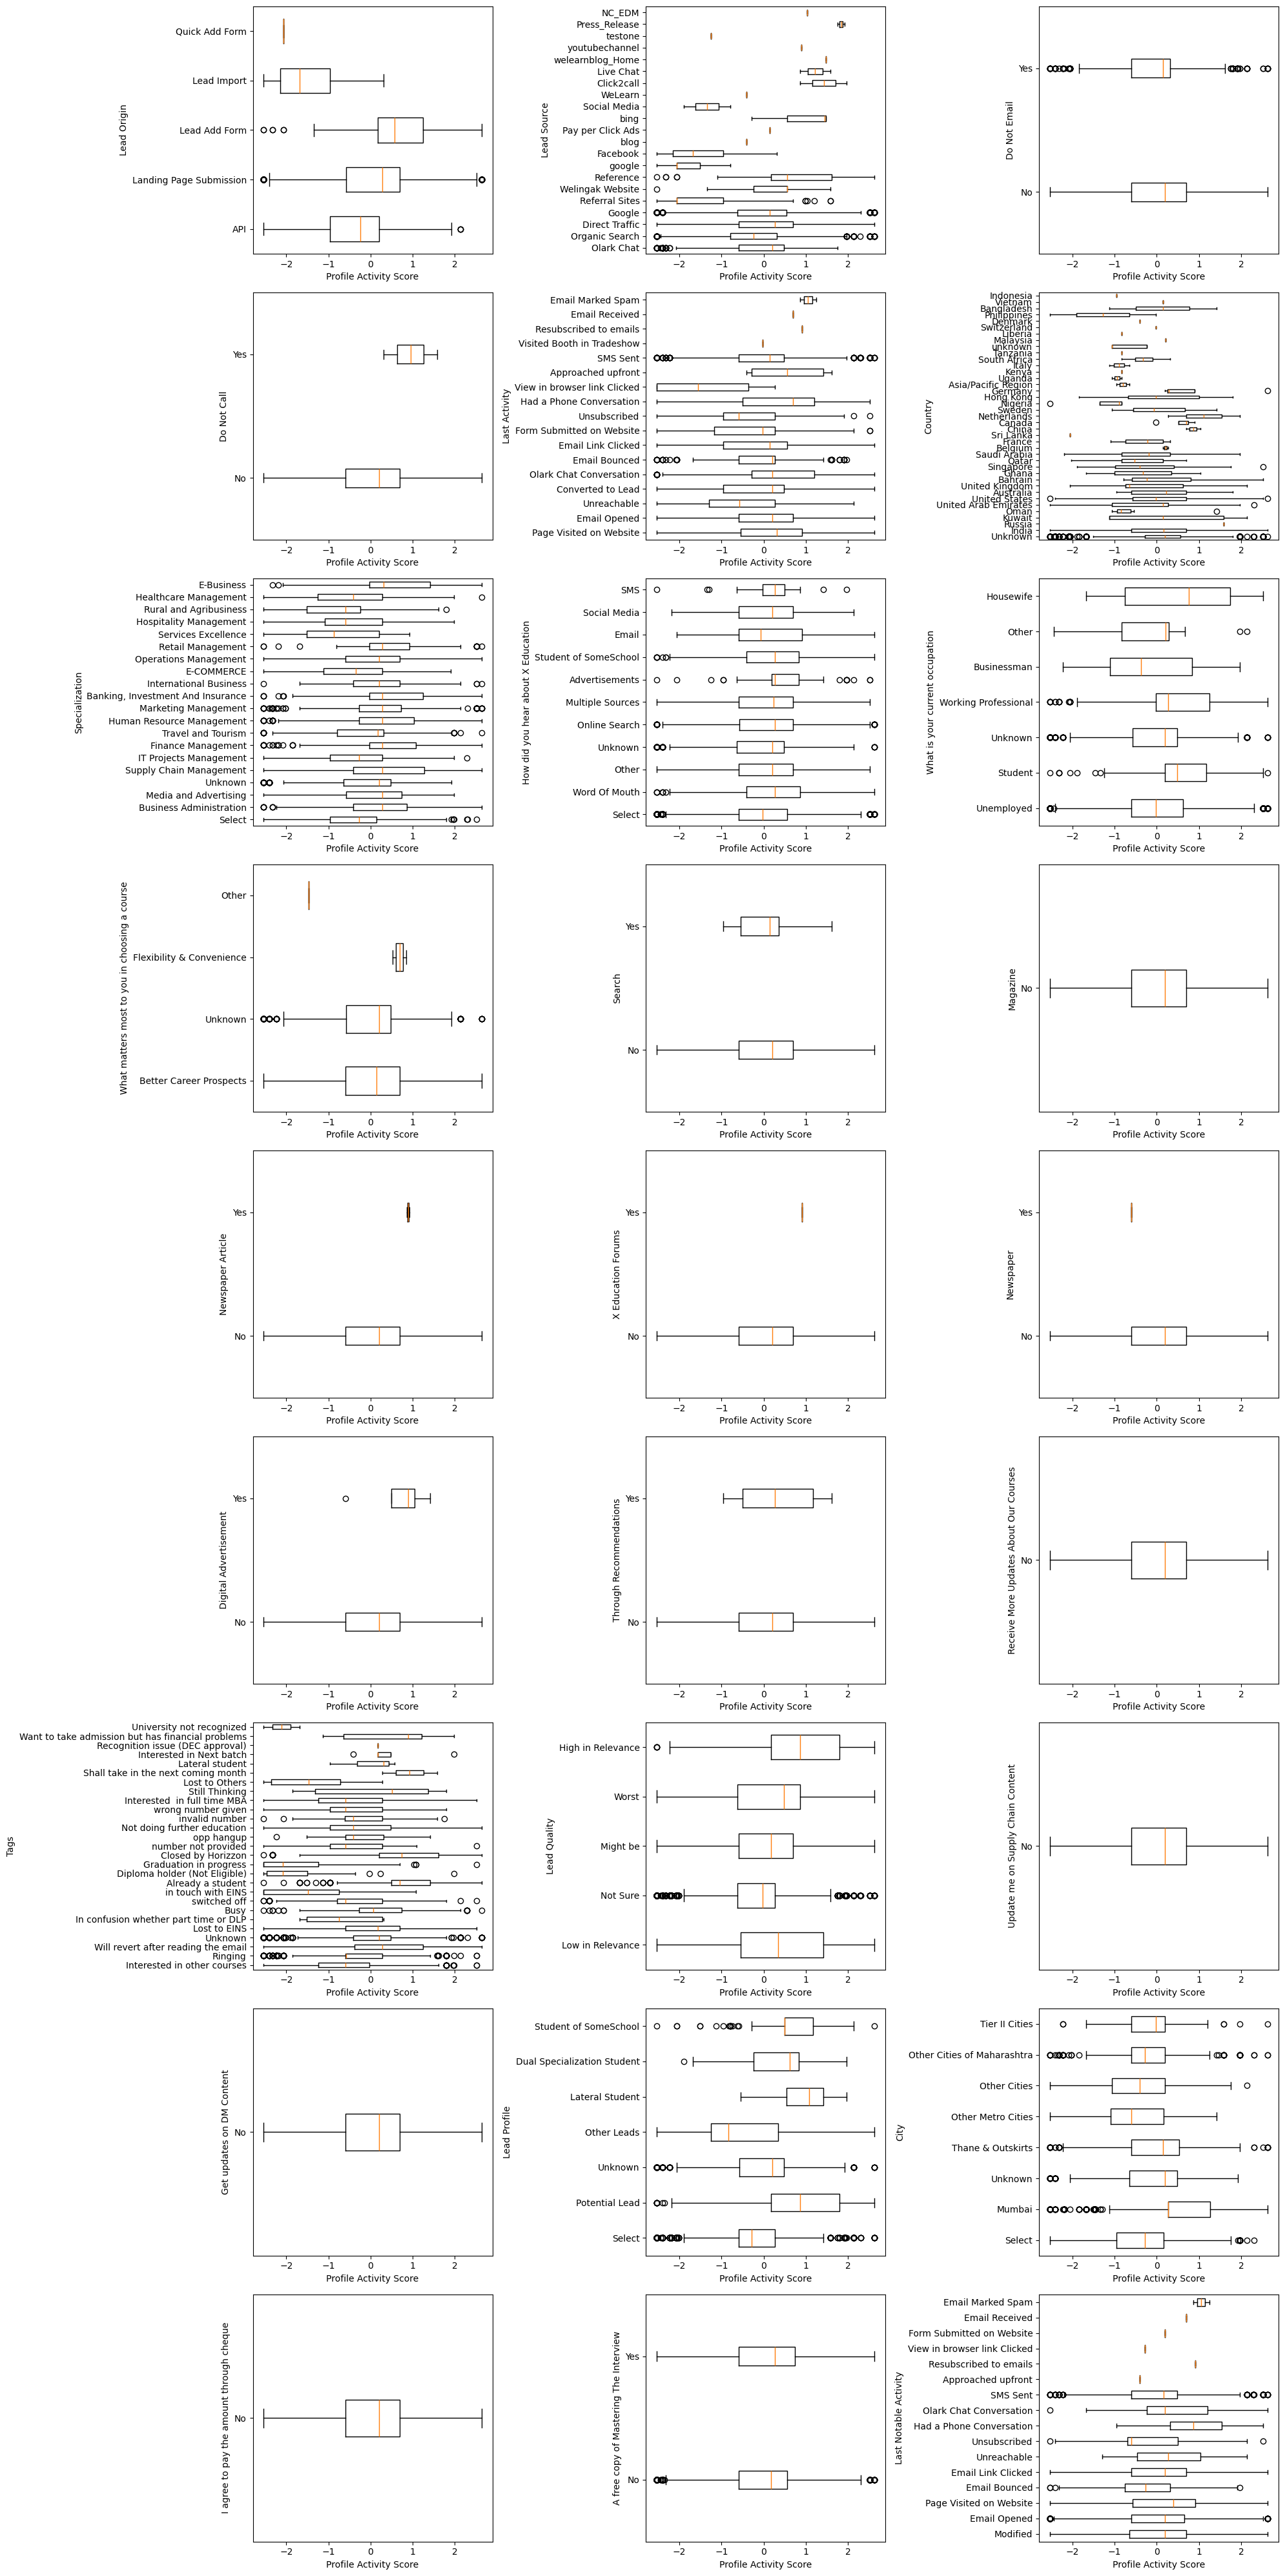

In [104]:
# Spread of numeric across category features
for numcol in numcols:
    print(numcol)
    box_plots(data, num_cols= [numcol], cat_cols= catcols, size= (20, 40), vertical= False)

In [106]:
'''
Tags, Last Activity, Last Notable Activity, Country and Lead Source has high dimensionality and have high variation
of numeric values across their unique category values. Thus converting all of them to dummies will create a very
large number of features resulting in a sparse design matrix and multicollinearity in model

Thus 2 approaches are used:
1. Use a balanced sampling approach to handle sparsity and diversity
2. Convert category features to numeric by using suitable transformation
'''

'\nTags, Last Activity, Last Notable Activity, Country and Lead Source has high dimensionality and have high variation\nof numeric values across their unique category values. Thus converting all of them to dummies will create a very\nlarge number of features resulting in a sparse design matrix and multicollinearity in model\n\nThus 2 approaches are used:\n1. Use a balanced sampling approach to handle sparsity and diversity\n2. Convert category features to numeric by using suitable transformation\n'

In [107]:
# Bivariate analysis: Numeric vs numeric

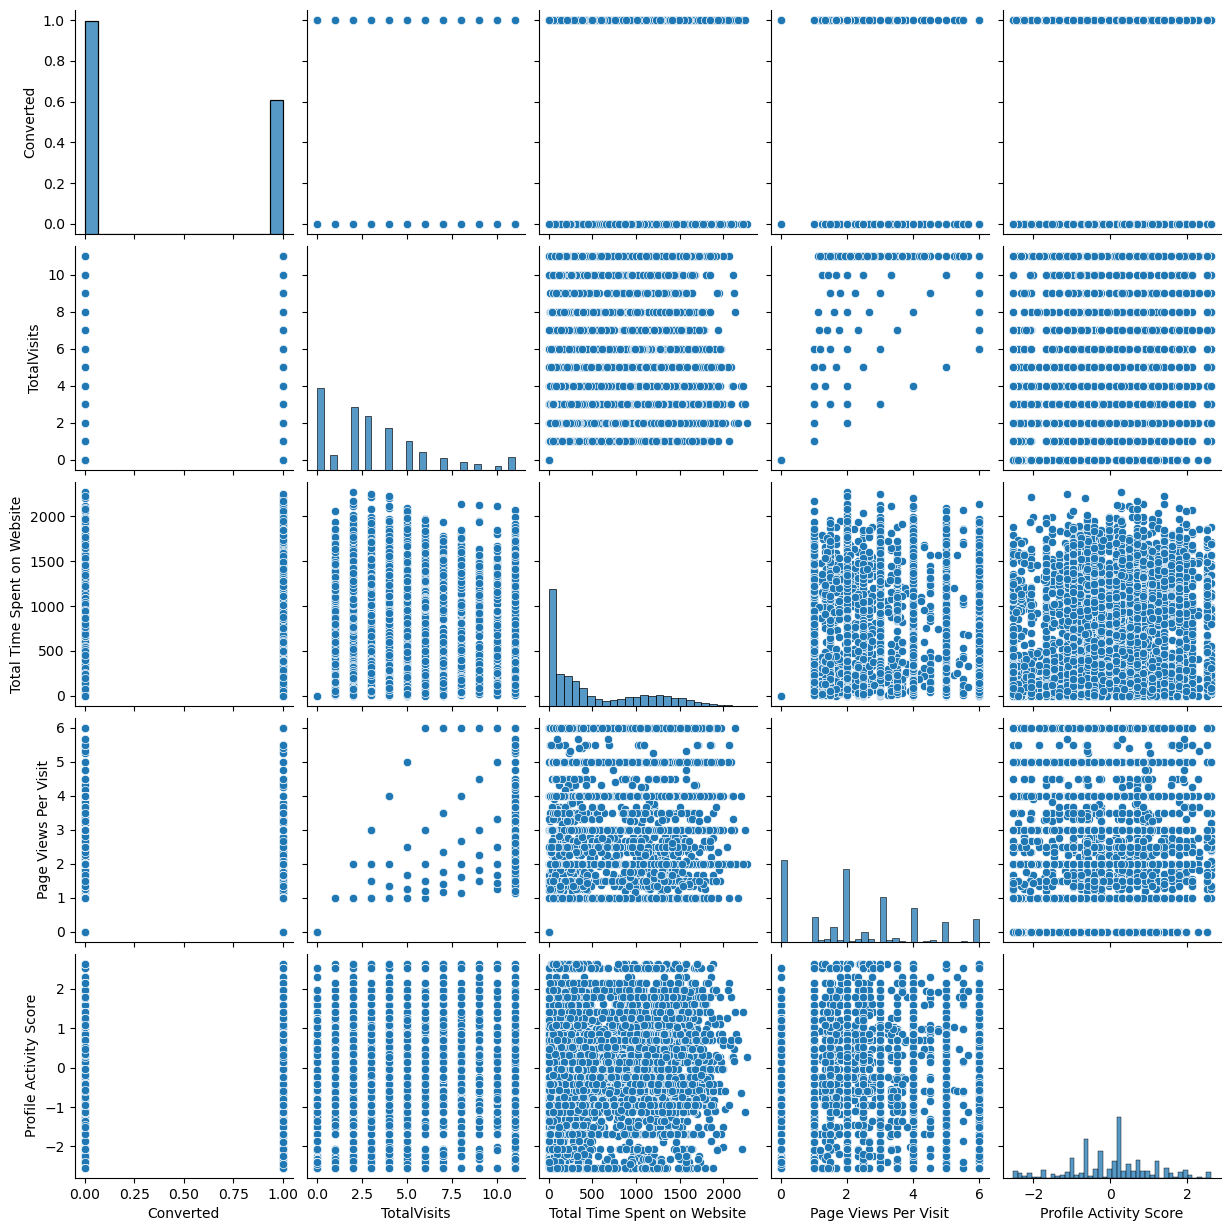

In [108]:
sns.pairplot(data[numcols])
plt.show()

In [109]:
# Page views and TotalVisits may be correlated

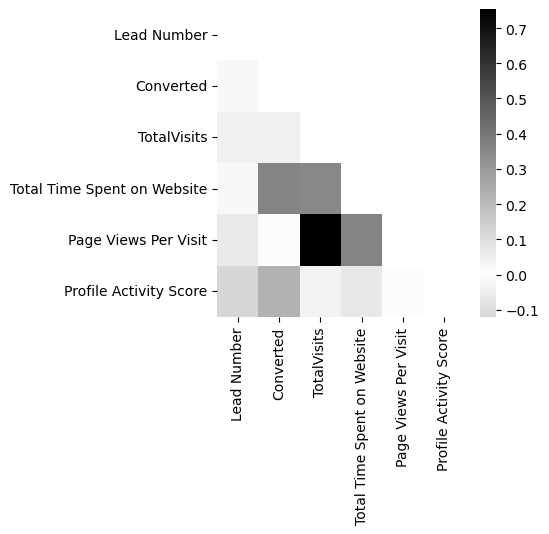

In [110]:
### Correlation Heatmap
df = data.select_dtypes(include=np.number).corr()
corr_heatmap(data, data.select_dtypes(include= np.number).columns, size = (4, 4))

In [111]:
## 5. Feature Engineering

'''
Two approaches to model building:

1. Converting category features to dummy variables, handling feature imbalances through SMOTE resampling, 
    and then tuning logistic regression model through GridSearchCV

2. Transforming category features to numeric using weight-of-evidence and log-odds transformation, 
    and tuning logistic regression model using p-values/vif

3. Accuracy of both models are then compared using target conversion ratio 

Using two approaches not only can the importance of individual feature can be predicted 
    but also can the importance of each unique value of category types be predicted
'''

'\nTwo approaches to model building:\n\n1. Converting category features to dummy variables, handling feature imbalances through SMOTE resampling, \n    and then tuning logistic regression model through GridSearchCV\n\n2. Transforming category features to numeric using weight-of-evidence and log-odds transformation, \n    and tuning logistic regression model using p-values/vif\n\n3. Accuracy of both models are then compared using target conversion ratio \n\nUsing two approaches not only can the importance of individual feature can be predicted \n    but also can the importance of each unique value of category types be predicted\n'

In [112]:
### Converting Binary Variables to 0, 1
binary_cols = data.drop('Converted', axis=1).columns[data.drop('Converted', axis=1).apply(lambda x: x.nunique()==2)]
binary_cols

Index(['Do Not Email', 'Do Not Call', 'Search', 'Newspaper Article',
       'X Education Forums', 'Newspaper', 'Digital Advertisement',
       'Through Recommendations', 'A free copy of Mastering The Interview'],
      dtype='object')

In [113]:
data[binary_cols] = data[binary_cols].apply(lambda x: x.map({'Yes': 1, 'No': 0}))

In [114]:
# Droppping unary columns because it will not influence model training
unary_cols = data.columns[data.apply(lambda x: x.nunique()==1)]
unary_cols

Index(['Magazine', 'Receive More Updates About Our Courses',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'I agree to pay the amount through cheque'],
      dtype='object')

In [115]:
data.drop(unary_cols, axis= 1, inplace= True)

In [116]:
# Approach 1

In [117]:
### Encoding Categorical Variables
data_balanced = pd.get_dummies(data, drop_first=True)

In [118]:
# 6. Splitting Data into Train and Test Sets
cols_to_drop = ['Converted', 'Prospect ID', 'Lead Number']
existing_cols_to_drop = [col for col in cols_to_drop if col in data_balanced.columns]
X = data_balanced.drop(existing_cols_to_drop, axis=1)
y = data_balanced['Converted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [119]:
# 7. Model Building

In [120]:
## Handling Class Imbalance with SMOTE
smt = SMOTE(random_state=42)
X_train, y_train = smt.fit_resample(X_train, y_train)

In [121]:
## Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [122]:
## Hyperparameter Tuning with GridSearchCV
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
grid = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)
model = grid.best_estimator_

In [123]:
'''
# Define a smaller search space for grid search
param_grid = {
    'C': [0.1, 1, 10],  # Smaller range for 'C'
    'penalty': ['l2'],  # Use only 'l2' penalty (skip 'l1' for simplicity)
    'solver': ['liblinear']  # Using 'liblinear' is fine for small datasets and L1 or L2 penalty
}

# Use GridSearchCV with parallel processing and 3-fold cross-validation
grid = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42),
                    param_grid, cv=3, scoring='roc_auc', n_jobs=-1)  # Use all cores for parallel processing

# Fit the model with training data
grid.fit(X_train, y_train)

# Get the best model
model = grid.best_estimator_


# 8.  Model Building with Class Weighting
#model = LogisticRegression(class_weight='balanced', random_state=42)
#model.fit(X_train, y_train)


'''

"\n# Define a smaller search space for grid search\nparam_grid = {\n    'C': [0.1, 1, 10],  # Smaller range for 'C'\n    'penalty': ['l2'],  # Use only 'l2' penalty (skip 'l1' for simplicity)\n    'solver': ['liblinear']  # Using 'liblinear' is fine for small datasets and L1 or L2 penalty\n}\n\n# Use GridSearchCV with parallel processing and 3-fold cross-validation\ngrid = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42),\n                    param_grid, cv=3, scoring='roc_auc', n_jobs=-1)  # Use all cores for parallel processing\n\n# Fit the model with training data\ngrid.fit(X_train, y_train)\n\n# Get the best model\nmodel = grid.best_estimator_\n\n\n# 8.  Model Building with Class Weighting\n#model = LogisticRegression(class_weight='balanced', random_state=42)\n#model.fit(X_train, y_train)\n\n\n"

In [124]:
# Predict probabilities
y_pred_prob = model.predict_proba(X_test)[:, 1]

In [125]:
# Adjusting threshold for better recall
threshold = 0.4
y_pred = (y_pred_prob >= threshold).astype(int)

In [126]:
# 8.Model Evaluation

In [127]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1576  128]
 [ 113  955]]
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.93      1704
         1.0       0.88      0.89      0.89      1068

    accuracy                           0.91      2772
   macro avg       0.91      0.91      0.91      2772
weighted avg       0.91      0.91      0.91      2772



In [128]:
# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.9651046886814019


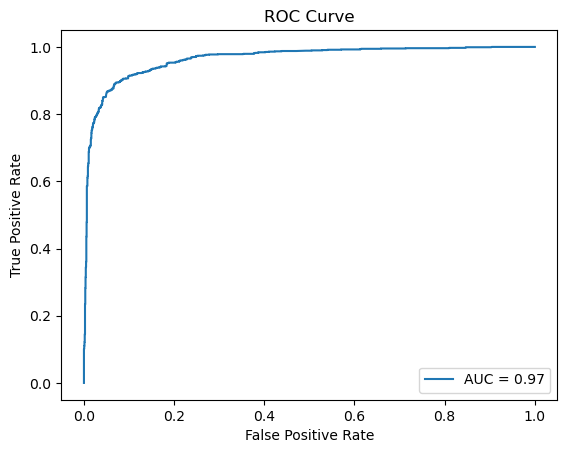

In [129]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [130]:
# Calculate Lead Scores
lead_scores = y_pred_prob * 100  # Scale probabilities to a range of 0-100

# Convert X_test back to a DataFrame
X_test_data= pd.DataFrame(X_test, columns=X.columns)  # Ensure correct column names
X_test_data['Lead Score'] = lead_scores
X_test_data['Converted'] = y_test.values  # Add the actual conversion labels for reference

In [131]:
# Display the top 10 leads with the highest scores
print("Top 10 Leads with Highest Scores:")
print(X_test_data[['Lead Score', 'Converted']].sort_values(by='Lead Score', ascending=False).head(10))

Top 10 Leads with Highest Scores:
      Lead Score  Converted
904    99.999970        1.0
2407   99.999959        1.0
1581   99.999882        1.0
338    99.999876        1.0
138    99.999876        1.0
1779   99.999876        1.0
797    99.999854        1.0
1826   99.999845        1.0
1620   99.999821        1.0
991    99.999821        1.0


In [132]:
X_test_data.head()

Do Not Email  Do Not Call  TotalVisits  Total Time Spent on Website  \
0     -0.269147    -0.015863    -1.142784                    -0.941055   
1     -0.269147    -0.015863    -0.424412                     0.958301   
2     -0.269147    -0.015863     2.808261                    -0.647890   
3     -0.269147    -0.015863    -0.783598                    -0.104201   
4     -0.269147    -0.015863    -0.783598                    -0.937501   

   Page Views Per Visit    Search  Newspaper Article  X Education Forums  \
0             -1.276606 -0.033665          -0.011216           -0.011216   
1             -0.141661 -0.033665          -0.011216           -0.011216   
2              1.560756 -0.033665          -0.011216           -0.011216   
3             -0.709133 -0.033665          -0.011216           -0.011216   
4             -0.709133 -0.033665          -0.011216           -0.011216   

   Newspaper  Digital Advertisement  ...  Last Notable Activity_Modified  \
0  -0.011216              -0.022437  ...                       -0.754510   
1  -0.011216              -0.022437  ...                       -0.754510   
2  -0.011216              -0.022437  ...                       -0.754510   
3  -0.011216              -0.022437  ...                        1.325363   
4  -0.011216              -0.022437  ...                        1.325363   

   Last Notable Activity_Olark Chat Conversation  \
0                                      -0.134857   
1                                      -0.134857   
2                                      -0.134857   
3                                      -0.134857   
4                                      -0.134857   

   Last Notable Activity_Page Visited on Website  \
0                                      -0.200418   
1                                      -0.200418   
2                                      -0.200418   
3                                      -0.200418   
4                                      -0.200418   

   Last Notable Activity_Resubscribed to emails  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   

   Last Notable Activity_SMS Sent  Last Notable Activity_Unreachable  \
0                       -0.661327                             -0.072   
1                       -0.661327                             -0.072   
2                        1.512112                             -0.072   
3                       -0.661327                             -0.072   
4                       -0.661327                             -0.072   

   Last Notable Activity_Unsubscribed  \
0                           -0.071112   
1                           -0.071112   
2                           -0.071112   
3                           -0.071112   
4                           -0.071112   

   Last Notable Activity_View in browser link Clicked  Lead Score  Converted  
0                                                0.0     0.526815        0.0  
1                                                0.0    99.940138        1.0  
2                                                0.0    32.698309        0.0  
3                                                0.0     0.032368        0.0  
4                                                0.0     0.003464        0.0  

[5 rows x 9428 columns]

In [133]:
pd.Series(model.coef_.reshape(-1), index= X.columns).sort_values(ascending= False)

Tags_Will revert after reading the email    1.550319
Total Time Spent on Website                 1.357848
Tags_Lost to EINS                           0.941338
Tags_Closed by Horizzon                     0.831208
Last Notable Activity_SMS Sent              0.755112
                                              ...   
Lead Quality_Not Sure                      -0.758465
Tags_switched off                          -0.786524
Lead Quality_Worst                         -0.841434
Tags_Interested in other courses           -0.893738
Tags_Ringing                               -1.691460
Length: 9426, dtype: float64

In [134]:
cutoff = 70  # Adjust the cutoff as needed

# Filter leads based on the cutoff
filtered_leads = X_test_data[X_test_data['Lead Score'] >= cutoff]

# Calculate the conversion ratio
conversion_ratio = filtered_leads['Converted'].sum() / len(filtered_leads)

print(f"Conversion Ratio at cutoff {cutoff}: {conversion_ratio:.2%}")

Conversion Ratio at cutoff 70: 92.63%


In [135]:
# Approach 2

In [136]:
# weight of evidence transform
catcols = data.drop('Prospect ID', axis=1).select_dtypes(include= 'O').columns

# woe = ln(converted for category / total converted) - ln(non converted for category / total non converted)
W = data[catcols].transform(lambda x: transform_catgory(data, x, 'Converted', woe))

# log-odds = ln (converted for category / non converted for category)
L = data[catcols].transform(lambda x: transform_catgory(data, x, 'Converted', log_odd))

# ratio_diff = (converted for category / total converted) - (non converted for category / total non converted)
R = data[catcols].transform(lambda x: transform_catgory(data, x, 'Converted', ratio_diff))

# Log-Odds transformation is used since it has higher total information value than WOE
print(f'Information value of WOE: \n{(W * R).sum(axis=0).sum()}')
print(f'\nInformation value of Log-Odds: \n{(L * R).sum(axis=0).sum()}')

Information value of WOE: 
21247.681528525573

Information value of Log-Odds: 
21667.46937574094


In [137]:
# plugging transformed category features to data
data_logOdds = pd.DataFrame()
numcols = data.select_dtypes(include= np.number).columns
catcols = data.select_dtypes(include= 'O').columns

data_logOdds = pd.concat([data[numcols], L], axis=1)
data_logOdds.shape == data.drop('Prospect ID', axis=1).shape

True

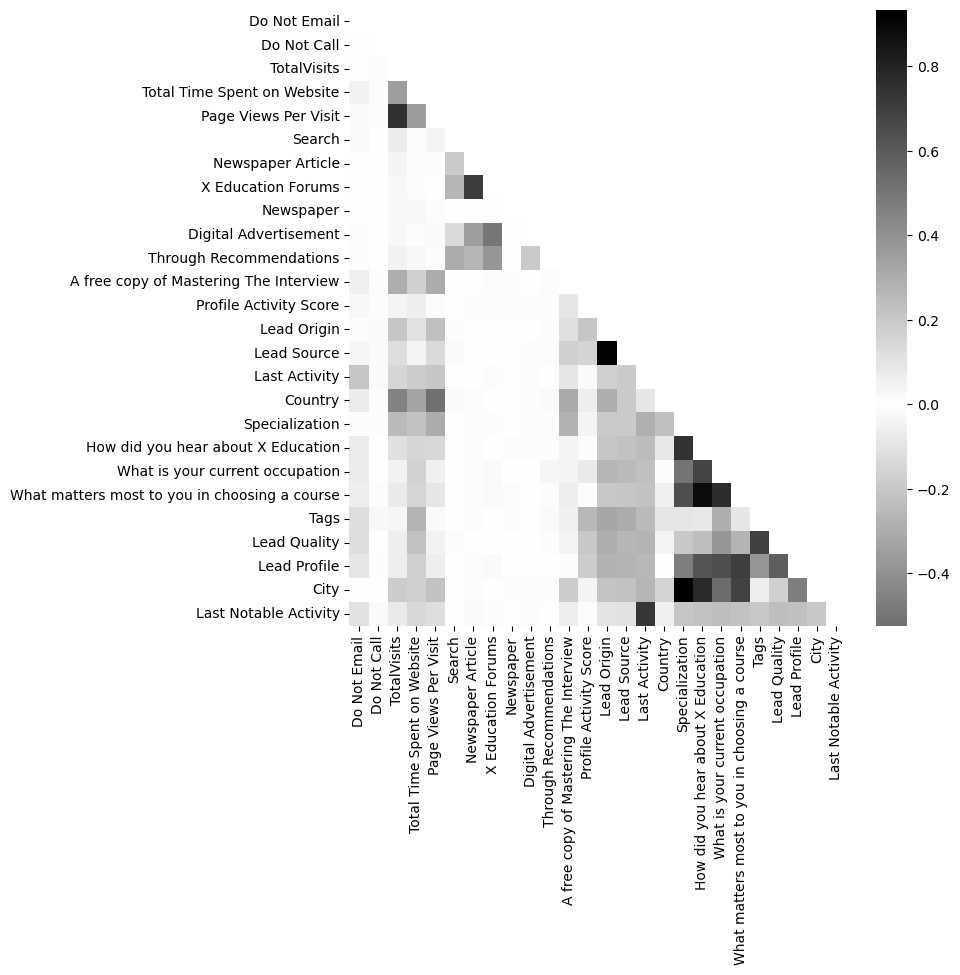

In [138]:
# Checking correlation heatmap. Correlated features may be eliminated during p-value / vif tuning

noplot = ['Converted', 'Lead Number']
df = data_logOdds.drop(noplot, axis=1)
corr_heatmap(df, df.columns, size=(8, 8))

In [139]:
# train test split for testing lead conversion after model tuning
train_logOdds, test_logOdds = train_test_split(data_logOdds, train_size= 0.7, random_state= 99)

Probability curves


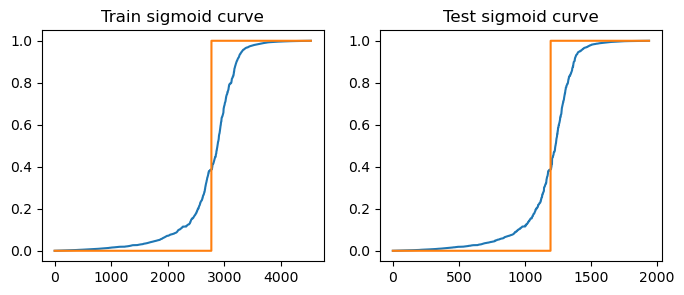

ROC curves


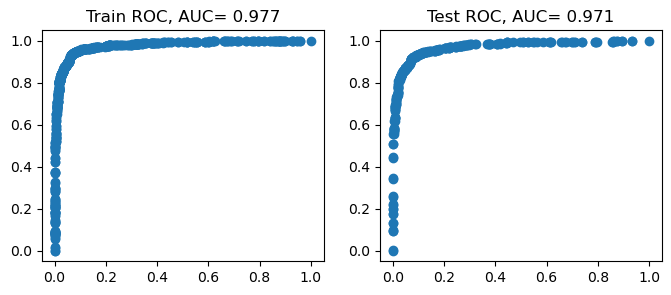

Results
                train      test
Accuracy     0.927988  0.919114
Sensitivity  0.876564  0.869973
Specificity  0.960636  0.949791
Precision    0.876564  0.869973
Recall       0.933939  0.915374


In [140]:
# Logistic Regression model based on scikit learn
model_initial = train_model(train_logOdds.drop('Lead Number', axis=1), target='Converted', train_size= 0.7, random_state= 42)

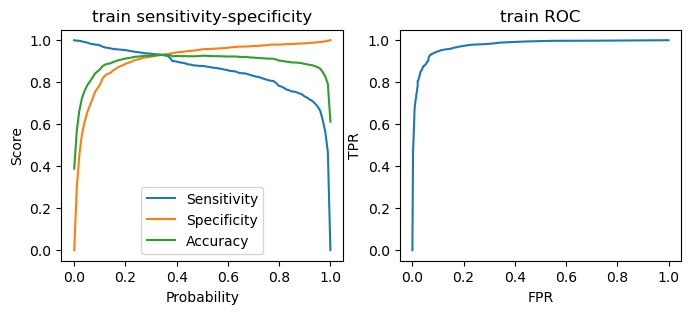

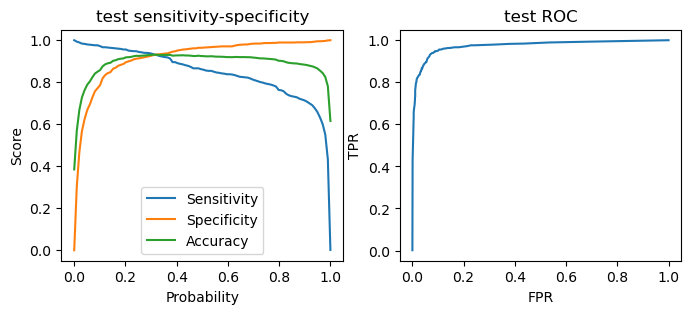

In [141]:
cutoff, confusion =  LogReg_Eval(train_logOdds.drop('Lead Number', axis=1), 
                                 target= 'Converted', model= model_initial, train_size= 0.7, random_state= 111)

In [142]:
print(cutoff)

{'train': 34.3, 'test': 31.3}


In [143]:
print(f'Sensitivity-specificity cutoff score: {cutoff}')
print(f'Train confusion matrix: \n{confusion['train']}')
print(f'Test confusion matrix: \n{confusion['test']}')

Sensitivity-specificity cutoff score: {'train': 34.3, 'test': 31.3}
Train confusion matrix: 
[[2576  194]
 [ 123 1634]]
Test confusion matrix: 
[[1111   83]
 [  51  696]]


In [144]:
# Tuning model for p-value / vif correction: cutoff p-value = 0.05, cutoff vif = 5, min feature = 8
# Lower VIF cutoff leads to lower conversion score, hence 5 is chosen as cutoff

result, summary = FeatureSelect_pvif(data_logOdds.drop('Lead Number', axis=1), f_count=8, 
                                     target='Converted', p_cutoff= 0.05, VIF_cutoff= 5, random_state= 133)

In [145]:
# Tuning summary function eliminates mostly on p-values
summary

Features  Vcount       Log_LH  \
0   Do Not Call,TotalVisits,Total Time Spent on We...      25 -1229.804936   
1   Do Not Call,TotalVisits,Total Time Spent on We...      24 -1229.804936   
2   TotalVisits,Total Time Spent on Website,Page V...      23 -1229.814848   
3   TotalVisits,Total Time Spent on Website,Page V...      22 -1229.839861   
4   TotalVisits,Total Time Spent on Website,Page V...      21 -1229.884552   
5   TotalVisits,Total Time Spent on Website,Page V...      20 -1229.886436   
6   TotalVisits,Total Time Spent on Website,Page V...      19 -1229.966333   
7   TotalVisits,Total Time Spent on Website,Page V...      18 -1230.406168   
8   TotalVisits,Total Time Spent on Website,Page V...      17 -1230.681487   
9   TotalVisits,Total Time Spent on Website,Page V...      16 -1232.085883   
10  TotalVisits,Total Time Spent on Website,Page V...      15 -1233.414301   
11  TotalVisits,Total Time Spent on Website,Page V...      14  -1234.94375   
12  TotalVisits,Total Time Spent on Website,Page V...      13 -1238.913176   

    Psu_Rsqr                        Reason                          Eliminated  
0   0.613479   Ft_Pval= 0.9995770774395751                           Newspaper  
1   0.613479   Ft_Pval= 0.9995371472980648                         Do Not Call  
2   0.613478   Ft_Pval= 0.9992398840722833                   Newspaper Article  
3   0.613475   Ft_Pval= 0.9991943331192666                  X Education Forums  
4    0.61347   Ft_Pval= 0.9507619686574383             Through Recommendations  
5    0.61347   Ft_Pval= 0.6891137799572132                        Lead Profile  
6    0.61346  Ft_Pval= 0.40994179621553006               Digital Advertisement  
7   0.613408  Ft_Pval= 0.41565821690087756                              Search  
8   0.613375  Ft_Pval= 0.10042901262588971     What is your current occupation  
9   0.613207  Ft_Pval= 0.10399059086004832  How did you hear about X Education  
10  0.613048   Ft_Pval= 0.0810561922159233                         Lead Origin  
11  0.612865     Ft_VIF= 9.690145881411537                      Specialization  
12  0.612389                            NA                                  NA

In [146]:
# Tuning results
result

Variables     Coeff        Ft_pval  \
1                                     TotalVisits  0.279754   3.998271e-04   
2                     Total Time Spent on Website  0.978954   1.725315e-62   
3                            Page Views Per Visit -0.603170   1.620315e-11   
4          A free copy of Mastering The Interview -0.281681   2.791756e-06   
5                          Profile Activity Score  0.259323   7.685548e-05   
6                                     Lead Source  0.314936   3.823928e-07   
7                                   Last Activity  0.512803   1.676252e-08   
8                                         Country  0.311728   1.101082e-05   
9   What matters most to you in choosing a course  0.474704   7.187420e-13   
10                                           Tags  3.053352  4.211082e-178   
11                                   Lead Quality -0.307346   1.637953e-03   
12                                           City  0.196200   4.048339e-03   
13                          Last Notable Activity  0.698013   8.507874e-20   

         VIF       Log_LH  Psu_Rsqr  
1   2.383825 -1238.913176  0.612389  
2   1.359018 -1238.913176  0.612389  
3   2.679643 -1238.913176  0.612389  
4   1.230013 -1238.913176  0.612389  
5   1.137602 -1238.913176  0.612389  
6   1.306683 -1238.913176  0.612389  
7   2.493532 -1238.913176  0.612389  
8   1.556123 -1238.913176  0.612389  
9   2.056552 -1238.913176  0.612389  
10  2.248509 -1238.913176  0.612389  
11  2.162210 -1238.913176  0.612389  
12  2.141596 -1238.913176  0.612389  
13  2.195893 -1238.913176  0.612389

In [147]:
# selecting tuned features from results
LogOdd_tuned = result['Variables']

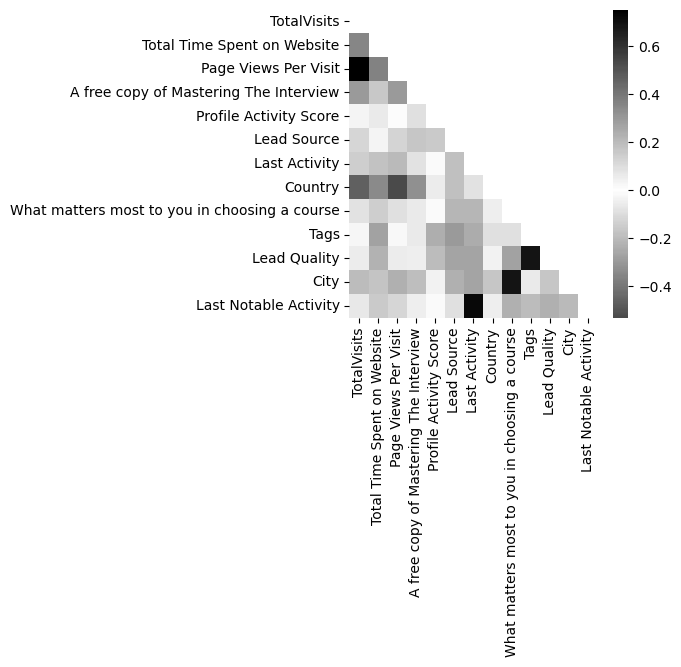

In [148]:
# Most of the correlated features have been eliminated, the rest are retained because of business importance
corr_heatmap(train_logOdds[LogOdd_tuned], LogOdd_tuned, size=(4, 4))

In [149]:
# Summary results of tuned model
cols = LogOdd_tuned.tolist() + ['Converted']
model_tuned = train_model(train_logOdds[cols], 'Converted', 0.7, 37, True)
cutoff_tuned, confusion_tuned = LogReg_Eval(train_logOdds[cols], 'Converted', model_tuned, 0.7, 666, True)

Results
                train      test
Accuracy     0.920919  0.930963
Sensitivity  0.867546  0.882895
Specificity  0.954366  0.961897
Precision    0.867546  0.882895
Recall       0.922561  0.937151


In [150]:
print(cutoff_tuned)

{'train': 33.4, 'test': 33.3}


In [151]:
# Final Lead Score cutoff value
print('Tuned cutoff = ',cutoff_tuned)
print('Tuned confusion matrix (train)\n', confusion_tuned['train'])
print('Tuned confusion matrix (train)\n', confusion_tuned['test'])

Tuned cutoff =  {'train': 33.4, 'test': 33.3}
Tuned confusion matrix (train)
 [[2580  206]
 [ 119 1622]]
Tuned confusion matrix (train)
 [[1089   89]
 [  55  708]]


In [152]:
# Features of tuned model
features_tuned = pd.Series(model_tuned.coef_[0], index= LogOdd_tuned)
features_tuned.sort_values(ascending= False)

Variables
Tags                                             2.970964
Total Time Spent on Website                      0.985064
Last Activity                                    0.642011
Last Notable Activity                            0.602886
What matters most to you in choosing a course    0.513450
Country                                          0.333949
Profile Activity Score                           0.324963
Lead Source                                      0.284580
TotalVisits                                      0.175937
City                                             0.103244
A free copy of Mastering The Interview          -0.258050
Lead Quality                                    -0.404739
Page Views Per Visit                            -0.470727
dtype: float64

In [153]:
# Top category features of tuned model
features_tuned[features_tuned.index.isin(data.select_dtypes(include='O').columns)].sort_values(ascending= False)

Variables
Tags                                             2.970964
Last Activity                                    0.642011
Last Notable Activity                            0.602886
What matters most to you in choosing a course    0.513450
Country                                          0.333949
Lead Source                                      0.284580
City                                             0.103244
Lead Quality                                    -0.404739
dtype: float64

In [154]:
# Adding Lead Scores to test dataset
scaler = StandardScaler()
scaler.fit(train_logOdds.drop(['Converted', 'Lead Number'], axis= 1)[features_tuned.index])
X_target = scaler.transform(test_logOdds.drop(['Converted', 'Lead Number'], axis= 1)[features_tuned.index])
test_logOdds['Lead Score'] = model_tuned.predict_proba(X_target)[:, 1] * 100

# Filtering Lead Numbers based on test dataset
hot_leads = test_logOdds.loc[test_logOdds['Lead Score'] > cutoff_tuned['test'], ['Lead Number', 'Converted']]
hot_leads

Lead Number  Converted
7734       590545        0.0
1881       641322        1.0
2512       635613        1.0
2870       632178        1.0
1682       642990        1.0
...           ...        ...
3186       629507        1.0
3266       628685        1.0
7265       593795        1.0
7838       589663        0.0
7566       591612        1.0

[1125 rows x 2 columns]

In [155]:
# Conversion ratio of cutoff predicted by tuned model
print(f'{(hot_leads['Converted'].sum() / len(hot_leads) * 100).round(2)} %')

88.18 %


In [156]:
# Since conversion ratio of approach 1 i better and it uses standard library function which is optimised, it is adopted as the final model.

In [157]:
## 10. Final conclusion

In [158]:
### 1. Top Three Variables Contributing to Lead Conversion
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_[0]})
coefficients['Absolute_Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='Absolute_Coefficient', ascending=False)

print("Top 3 Contributing Variables:")
print(coefficients.head(3))

Top 3 Contributing Variables:
                                       Feature  Coefficient  \
9381                              Tags_Ringing    -1.691460   
9387  Tags_Will revert after reading the email     1.550319   
3                  Total Time Spent on Website     1.357848   

      Absolute_Coefficient  
9381              1.691460  
9387              1.550319  
3                 1.357848  


In [159]:
### 2. Top 3 Categorical/Dummy Variables to Focus On
categorical_features = [col for col in X.columns if '_' in col or col in binary_cols]
categorical_coefficients = coefficients[coefficients['Feature'].isin(categorical_features)]
categorical_coefficients = categorical_coefficients.sort_values(by='Absolute_Coefficient', ascending=False)

print("Top 3 Categorical/Dummy Variables:")
print(categorical_coefficients.head(3))

Top 3 Categorical/Dummy Variables:
                                       Feature  Coefficient  \
9381                              Tags_Ringing    -1.691460   
9387  Tags_Will revert after reading the email     1.550319   
9377                         Tags_Lost to EINS     0.941338   

      Absolute_Coefficient  
9381              1.691460  
9387              1.550319  
9377              0.941338  


In [160]:
### 3. Strategy for Aggressive Lead Conversion
# Adjusting threshold to 0.3 for aggressive conversion
aggressive_threshold = 0.3
y_aggressive_pred = (y_pred_prob >= aggressive_threshold).astype(int)
print("Number of Leads Targeted with Threshold 0.3:", sum(y_aggressive_pred))

Number of Leads Targeted with Threshold 0.3: 1127


In [161]:
# Aggressive conversion ratio
(X_test_data['Converted']==1).sum() / sum(y_aggressive_pred)

0.9476486246672582

In [162]:
### 4. Strategy for Minimizing Useless Phone Calls
# Adjusting threshold to 0.8 for minimizing unnecessary calls
minimal_calls_threshold = 0.7
y_minimal_calls_pred = (y_pred_prob >= minimal_calls_threshold).astype(int)
print("Number of Leads Targeted with Threshold 0.7:", sum(y_minimal_calls_pred))

Number of Leads Targeted with Threshold 0.7: 977


In [163]:
# Aggressive conversion ratio
(X_test_data['Converted']==1).sum() / sum(y_minimal_calls_pred)

1.0931422722620265

## Recommendations

•Continuous Monitoring: Regularly evaluate the model’s performance and recalibrate thresholds based on seasonal trends or campaign goals.


•Targeted Interventions: Invest in understanding and addressing reasons behind negative impact variables (e.g., Tags_Ringing).


•Data-Driven Decisions: Use insights from the model to inform marketing strategies, such as prioritizing website engagement initiatives.

•Sales-personnel training: Training sales personnel to categorize prospects who have not mentioned any course preference, or 
contact prospects to get their course preference

•Upgrading website: upgrading website to filter bot activity from actual user activity